
# **Data Processing**

Installing Times New Roman font...
✓ Font installation complete
PULTRUSION PARAMETRIC STUDY DATA PROCESSOR

Enter minimum velocity (m/min): 0.11
Enter maximum velocity (m/min): 0.21
Enter velocity step (m/min): 0.01

Enter minimum die temperature (°C): 110
Enter maximum die temperature (°C): 140
Enter temperature step (°C): 10

Velocities: [0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21]
Temperatures: [110. 120. 130. 140.]
Total number of cases: 44

Please upload the 'cure' file:


Saving Cure_Data.txt to Cure_Data (1).txt

Please upload the 'temperature' file:


Saving Temp_Data.txt to Temp_Data (1).txt

Processing cure data...
Points per case: 143
Processing temperature data...
Creating summary statistics...
Exporting to Excel...
Excel file 'pultrusion_results.xlsx' created successfully!

Creating high-resolution design charts for publication...


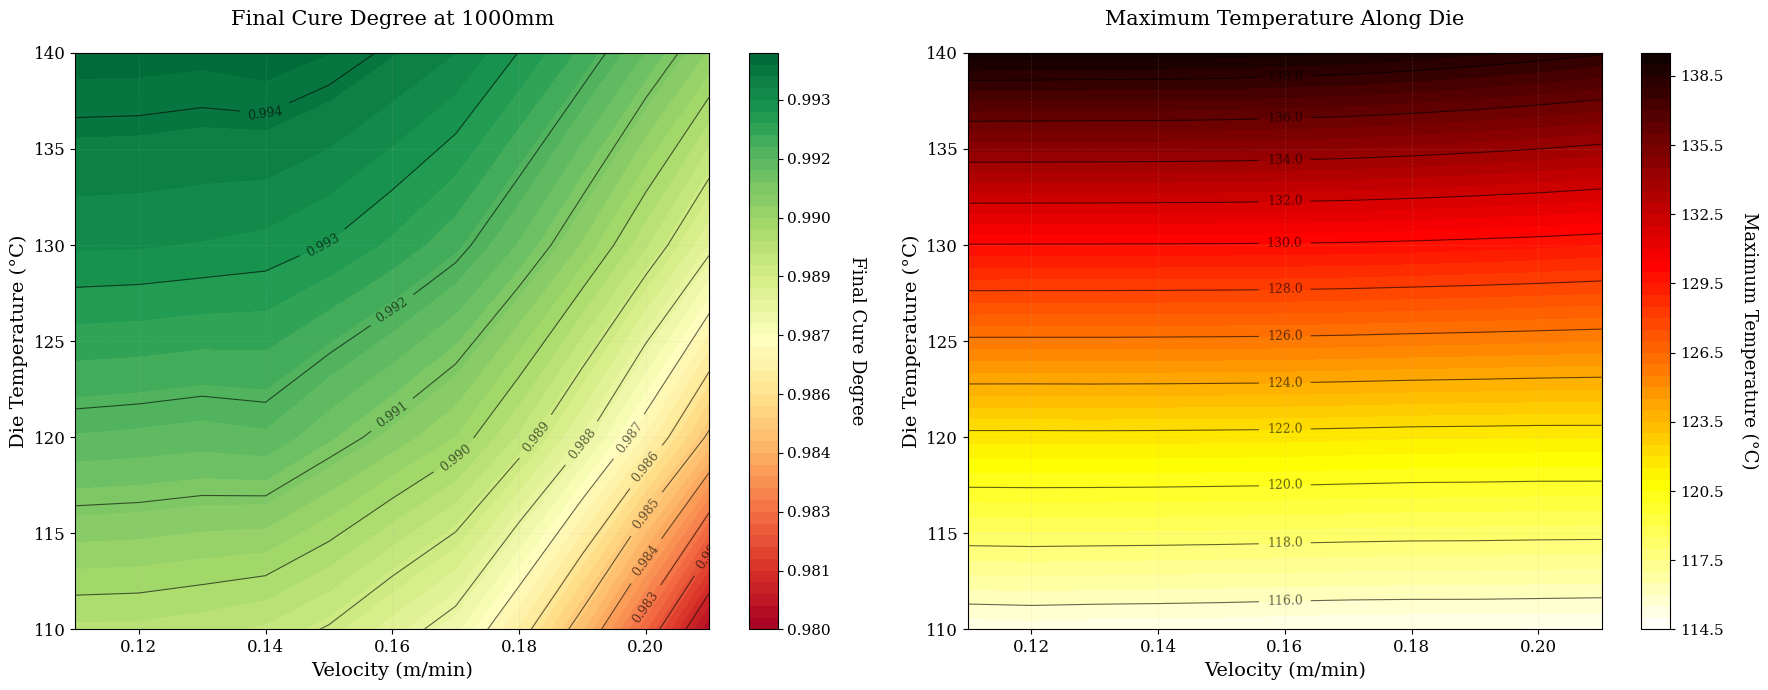

High-resolution design charts saved:
  - design_charts_publication.png (600 dpi)
  - design_charts_publication.pdf (vector)
  - design_charts_publication.eps (vector)

Creating high-resolution 3D surface plots...


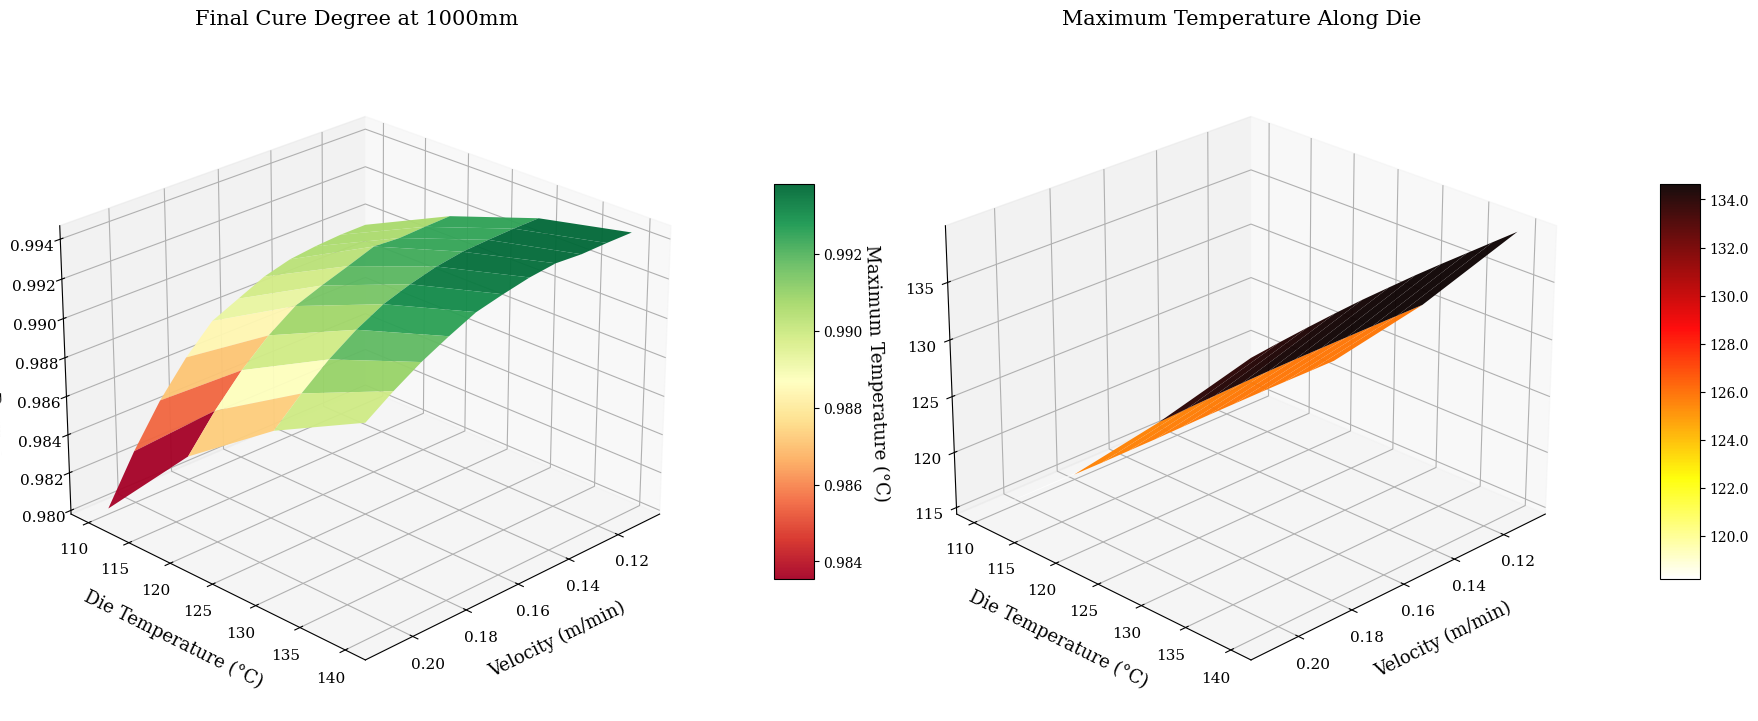

High-resolution 3D charts saved:
  - design_charts_3d_publication.png (600 dpi)
  - design_charts_3d_publication.pdf (vector)
  - design_charts_3d_publication.eps (vector)

PROCESSING COMPLETE!

Generated files:

📊 Excel File:
  • pultrusion_results.xlsx

📈 2D Contour Plots (Publication Quality - 600 DPI):
  • design_charts_publication.png
  • design_charts_publication.pdf (vector)
  • design_charts_publication.eps (vector)

📉 3D Surface Plots (Publication Quality - 600 DPI):
  • design_charts_3d_publication.png
  • design_charts_3d_publication.pdf (vector)
  • design_charts_3d_publication.eps (vector)

Files are ready in your Colab environment.
Access them from the Files panel on the left.
PDF and EPS formats are vector graphics, ideal for journals.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import griddata
import openpyxl
from openpyxl.styles import Font, PatternFill, Alignment
from google.colab import files
import subprocess
import os

# ===== INSTALL TIMES NEW ROMAN FONT =====
print("Installing Times New Roman font...")
try:
    subprocess.run(['apt-get', 'install', '-y', 'msttcorefonts', '-qq'],
                   stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    # Remove matplotlib font cache
    subprocess.run(['rm', '-rf', os.path.expanduser('~/.cache/matplotlib')],
                   stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    print("✓ Font installation complete")
except:
    print("Note: Using default serif font")

# Set font to Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif', 'Liberation Serif']
plt.rcParams['mathtext.fontset'] = 'stix'

# ===== INPUT PARAMETERS =====
print("=" * 60)
print("PULTRUSION PARAMETRIC STUDY DATA PROCESSOR")
print("=" * 60)

# Get velocity range
vel_min = float(input("\nEnter minimum velocity (m/min): "))
vel_max = float(input("Enter maximum velocity (m/min): "))
vel_step = float(input("Enter velocity step (m/min): "))

# Get temperature range
temp_min = float(input("\nEnter minimum die temperature (°C): "))
temp_max = float(input("Enter maximum die temperature (°C): "))
temp_step = float(input("Enter temperature step (°C): "))

# Generate parameter arrays
velocities = np.arange(vel_min, vel_max + vel_step/2, vel_step)
temperatures = np.arange(temp_min, temp_max + temp_step/2, temp_step)

print(f"\nVelocities: {velocities}")
print(f"Temperatures: {temperatures}")
print(f"Total number of cases: {len(velocities) * len(temperatures)}")

# ===== UPLOAD FILES =====
print("\n" + "=" * 60)
print("Please upload the 'cure' file:")
uploaded_cure = files.upload()
cure_filename = list(uploaded_cure.keys())[0]

print("\nPlease upload the 'temperature' file:")
uploaded_temp = files.upload()
temp_filename = list(uploaded_temp.keys())[0]

# ===== PROCESS CURE DATA =====
print("\n" + "=" * 60)
print("Processing cure data...")

# Read the cure file
cure_data = pd.read_csv(cure_filename, sep=r'\s+', header=None, names=['Axial_Distance', 'Cure_Degree'])

# Determine number of points per case (assuming distance goes from 0 to 1000)
axial_distances = cure_data['Axial_Distance'].values
# Find where the pattern repeats (when distance resets)
reset_indices = np.where(np.diff(axial_distances) < 0)[0] + 1
if len(reset_indices) > 0:
    points_per_case = reset_indices[0]
else:
    points_per_case = len(axial_distances)

print(f"Points per case: {points_per_case}")

# Create organized cure dataframe
cure_organized = pd.DataFrame()
cure_organized['Axial_Distance'] = axial_distances[:points_per_case]

case_idx = 0
for vel in velocities:
    for temp in temperatures:
        start_idx = case_idx * points_per_case
        end_idx = start_idx + points_per_case
        col_name = f'V={vel:.2f}_T={temp:.0f}'
        cure_organized[col_name] = cure_data['Cure_Degree'].values[start_idx:end_idx]
        case_idx += 1

# ===== PROCESS TEMPERATURE DATA =====
print("Processing temperature data...")

# Read the temperature file
temp_data = pd.read_csv(temp_filename, sep=r'\s+', header=None, names=['Axial_Distance', 'Die_Temperature'])

# Create organized temperature dataframe
temp_organized = pd.DataFrame()
temp_organized['Axial_Distance'] = axial_distances[:points_per_case]

case_idx = 0
for vel in velocities:
    for temp in temperatures:
        start_idx = case_idx * points_per_case
        end_idx = start_idx + points_per_case
        col_name = f'V={vel:.2f}_T={temp:.0f}'
        temp_organized[col_name] = temp_data['Die_Temperature'].values[start_idx:end_idx]
        case_idx += 1

# ===== CREATE SUMMARY DATAFRAME =====
print("Creating summary statistics...")

summary_data = []
for vel in velocities:
    for temp in temperatures:
        col_name = f'V={vel:.2f}_T={temp:.0f}'

        # Final cure degree at 1000mm (last value)
        final_cure = cure_organized[col_name].iloc[-1]

        # Maximum temperature along the die
        max_temp = temp_organized[col_name].max()

        summary_data.append({
            'Velocity (m/min)': vel,
            'Die Temperature (°C)': temp,
            'Final Cure Degree at 1000mm': final_cure,
            'Maximum Temperature (°C)': max_temp
        })

summary_df = pd.DataFrame(summary_data)

# ===== EXPORT TO EXCEL =====
print("Exporting to Excel...")

with pd.ExcelWriter('pultrusion_results.xlsx', engine='openpyxl') as writer:
    # Sheet 1: Summary
    summary_df.to_excel(writer, sheet_name='Summary', index=False)

    # Sheet 2: Cure Data
    cure_organized.to_excel(writer, sheet_name='Cure_Degree', index=False)

    # Sheet 3: Temperature Data
    temp_organized.to_excel(writer, sheet_name='Die_Temperature', index=False)

# Format the Excel file
wb = openpyxl.load_workbook('pultrusion_results.xlsx')
ws_summary = wb['Summary']

# Format headers
header_fill = PatternFill(start_color='366092', end_color='366092', fill_type='solid')
header_font = Font(bold=True, color='FFFFFF')

for cell in ws_summary[1]:
    cell.fill = header_fill
    cell.font = header_font
    cell.alignment = Alignment(horizontal='center', vertical='center')

# Auto-adjust column widths
for column in ws_summary.columns:
    max_length = 0
    column = [cell for cell in column]
    for cell in column:
        try:
            if len(str(cell.value)) > max_length:
                max_length = len(cell.value)
        except:
            pass
    adjusted_width = (max_length + 2)
    ws_summary.column_dimensions[column[0].column_letter].width = adjusted_width

wb.save('pultrusion_results.xlsx')

print("Excel file 'pultrusion_results.xlsx' created successfully!")

# ===== CREATE DESIGN CHARTS =====
print("\nCreating high-resolution design charts for publication...")

# Prepare data for contour plots
vel_grid, temp_grid = np.meshgrid(velocities, temperatures)

# Reshape data for plotting
cure_matrix = summary_df['Final Cure Degree at 1000mm'].values.reshape(len(velocities), len(temperatures)).T
temp_max_matrix = summary_df['Maximum Temperature (°C)'].values.reshape(len(velocities), len(temperatures)).T

# Determine contour levels for cure degree (0.001 step)
cure_min = cure_matrix.min()
cure_max = cure_matrix.max()
cure_levels_contour = np.arange(np.floor(cure_min * 1000) / 1000,
                                 np.ceil(cure_max * 1000) / 1000 + 0.001,
                                 0.001)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Final Cure Degree
contour1 = ax1.contourf(vel_grid, temp_grid, cure_matrix, levels=50, cmap='RdYlGn')
#contour1_lines = ax1.contour(vel_grid, temp_grid, cure_matrix, levels=cure_levels_contour,
#                              colors='black', linewidths=0.8, alpha=0.6)
contour1_lines = ax1.contour(vel_grid, temp_grid, cure_matrix, levels=15,
                              colors='black', linewidths=0.8, alpha=0.6)
ax1.clabel(contour1_lines, inline=True, fontsize=9, fmt='%.3f', inline_spacing=8)
cbar1 = plt.colorbar(contour1, ax=ax1, format='%.3f')
cbar1.set_label('Final Cure Degree', rotation=270, labelpad=25, fontsize=13)
cbar1.ax.tick_params(labelsize=11)
ax1.set_xlabel('Velocity (m/min)', fontsize=14)
ax1.set_ylabel('Die Temperature (°C)', fontsize=14)
ax1.set_title('Final Cure Degree at 1000mm', fontsize=15, pad=20)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)

# Plot 2: Maximum Temperature
contour2 = ax2.contourf(vel_grid, temp_grid, temp_max_matrix, levels=50, cmap='hot_r')
contour2_lines = ax2.contour(vel_grid, temp_grid, temp_max_matrix, levels=15,
                              colors='black', linewidths=0.8, alpha=0.6)
ax2.clabel(contour2_lines, inline=True, fontsize=9, fmt='%.1f', inline_spacing=8)
cbar2 = plt.colorbar(contour2, ax=ax2, format='%.1f')
cbar2.set_label('Maximum Temperature (°C)', rotation=270, labelpad=25, fontsize=13)
cbar2.ax.tick_params(labelsize=11)
ax2.set_xlabel('Velocity (m/min)', fontsize=14)
ax2.set_ylabel('Die Temperature (°C)', fontsize=14)
ax2.set_title('Maximum Temperature Along Die', fontsize=15, pad=20)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('design_charts_publication.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('design_charts_publication.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('design_charts_publication.eps', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print("High-resolution design charts saved:")
print("  - design_charts_publication.png (600 dpi)")
print("  - design_charts_publication.pdf (vector)")
print("  - design_charts_publication.eps (vector)")

# ===== CREATE 3D SURFACE PLOTS =====
print("\nCreating high-resolution 3D surface plots...")

fig = plt.figure(figsize=(18, 7))

# 3D plot 1: Final Cure Degree
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(vel_grid, temp_grid, cure_matrix, cmap='RdYlGn',
                          edgecolor='none', alpha=0.95, antialiased=True,
                          linewidth=0, shade=True)
ax1.set_xlabel('Velocity (m/min)', fontsize=13, labelpad=10)
ax1.set_ylabel('Die Temperature (°C)', fontsize=13, labelpad=10)
ax1.set_zlabel('Final Cure Degree', fontsize=13, labelpad=10)
ax1.set_title('Final Cure Degree at 1000mm', fontsize=15, pad=20)
ax1.tick_params(axis='both', which='major', labelsize=11)
ax1.view_init(elev=25, azim=45)
cbar1 = fig.colorbar(surf1, ax=ax1, shrink=0.6, aspect=10, pad=0.1, format='%.3f')
cbar1.ax.tick_params(labelsize=10)

# 3D plot 2: Maximum Temperature
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(vel_grid, temp_grid, temp_max_matrix, cmap='hot_r',
                          edgecolor='none', alpha=0.95, antialiased=True,
                          linewidth=0, shade=True)
ax2.set_xlabel('Velocity (m/min)', fontsize=13, labelpad=10)
ax2.set_ylabel('Die Temperature (°C)', fontsize=13, labelpad=10)
ax2.set_zlabel('Maximum Temperature (°C)', fontsize=13, labelpad=10)
ax2.set_title('Maximum Temperature Along Die', fontsize=15, pad=20)
ax2.tick_params(axis='both', which='major', labelsize=11)
ax2.view_init(elev=25, azim=45)
cbar2 = fig.colorbar(surf2, ax=ax2, shrink=0.6, aspect=10, pad=0.1, format='%.1f')
cbar2.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.savefig('design_charts_3d_publication.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('design_charts_3d_publication.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('design_charts_3d_publication.eps', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print("High-resolution 3D charts saved:")
print("  - design_charts_3d_publication.png (600 dpi)")
print("  - design_charts_3d_publication.pdf (vector)")
print("  - design_charts_3d_publication.eps (vector)")

# ===== SUMMARY =====
print("\n" + "=" * 60)
print("PROCESSING COMPLETE!")
print("=" * 60)
print("\nGenerated files:")
print("\n📊 Excel File:")
print("  • pultrusion_results.xlsx")
print("\n📈 2D Contour Plots (Publication Quality - 600 DPI):")
print("  • design_charts_publication.png")
print("  • design_charts_publication.pdf (vector)")
print("  • design_charts_publication.eps (vector)")
print("\n📉 3D Surface Plots (Publication Quality - 600 DPI):")
print("  • design_charts_3d_publication.png")
print("  • design_charts_3d_publication.pdf (vector)")
print("  • design_charts_3d_publication.eps (vector)")
print("\n" + "=" * 60)
print("Files are ready in your Colab environment.")
print("Access them from the Files panel on the left.")
print("PDF and EPS formats are vector graphics, ideal for journals.")
print("=" * 60)

# Training Neural Network, Random Forest and Gradient Boosting

Installing Times New Roman font...
✓ Font installation complete
PULTRUSION PARAMETRIC STUDY DATA PROCESSOR

Enter minimum velocity (m/min): 0.11
Enter maximum velocity (m/min): 0.21
Enter velocity step (m/min): 0.01

Enter minimum die temperature (°C): 110
Enter maximum die temperature (°C): 140
Enter temperature step (°C): 10

Velocities: [0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21]
Temperatures: [110. 120. 130. 140.]
Total number of cases: 44

Please upload the 'cure' file:


Saving Cure_Data.txt to Cure_Data (2).txt

Please upload the 'temperature' file:


Saving Temp_Data.txt to Temp_Data (2).txt

Processing cure data...
Points per case: 143
Processing temperature data...
Creating summary statistics...

MACHINE LEARNING MODEL TRAINING

Preparing training data...
✓ Training samples: 5033
✓ Testing samples: 1259

------------------------------------------------------------
Training Cure Degree Prediction Models...
------------------------------------------------------------

1. Neural Network (MLP)...
   R² = 0.999797, MSE = 0.00003837, MAE = 0.00386172

2. Random Forest...
   R² = 0.998563, MSE = 0.00027089, MAE = 0.00563014

3. Gradient Boosting...
   R² = 0.999480, MSE = 0.00009807, MAE = 0.00357732

------------------------------------------------------------
Training Temperature Prediction Models...
------------------------------------------------------------

1. Neural Network (MLP)...
   R² = 0.998980, MSE = 1.30042498, MAE = 0.70740634

2. Random Forest...
   R² = 0.999455, MSE = 0.69526044, MAE = 0.39785374

3. Gradient Boosting.

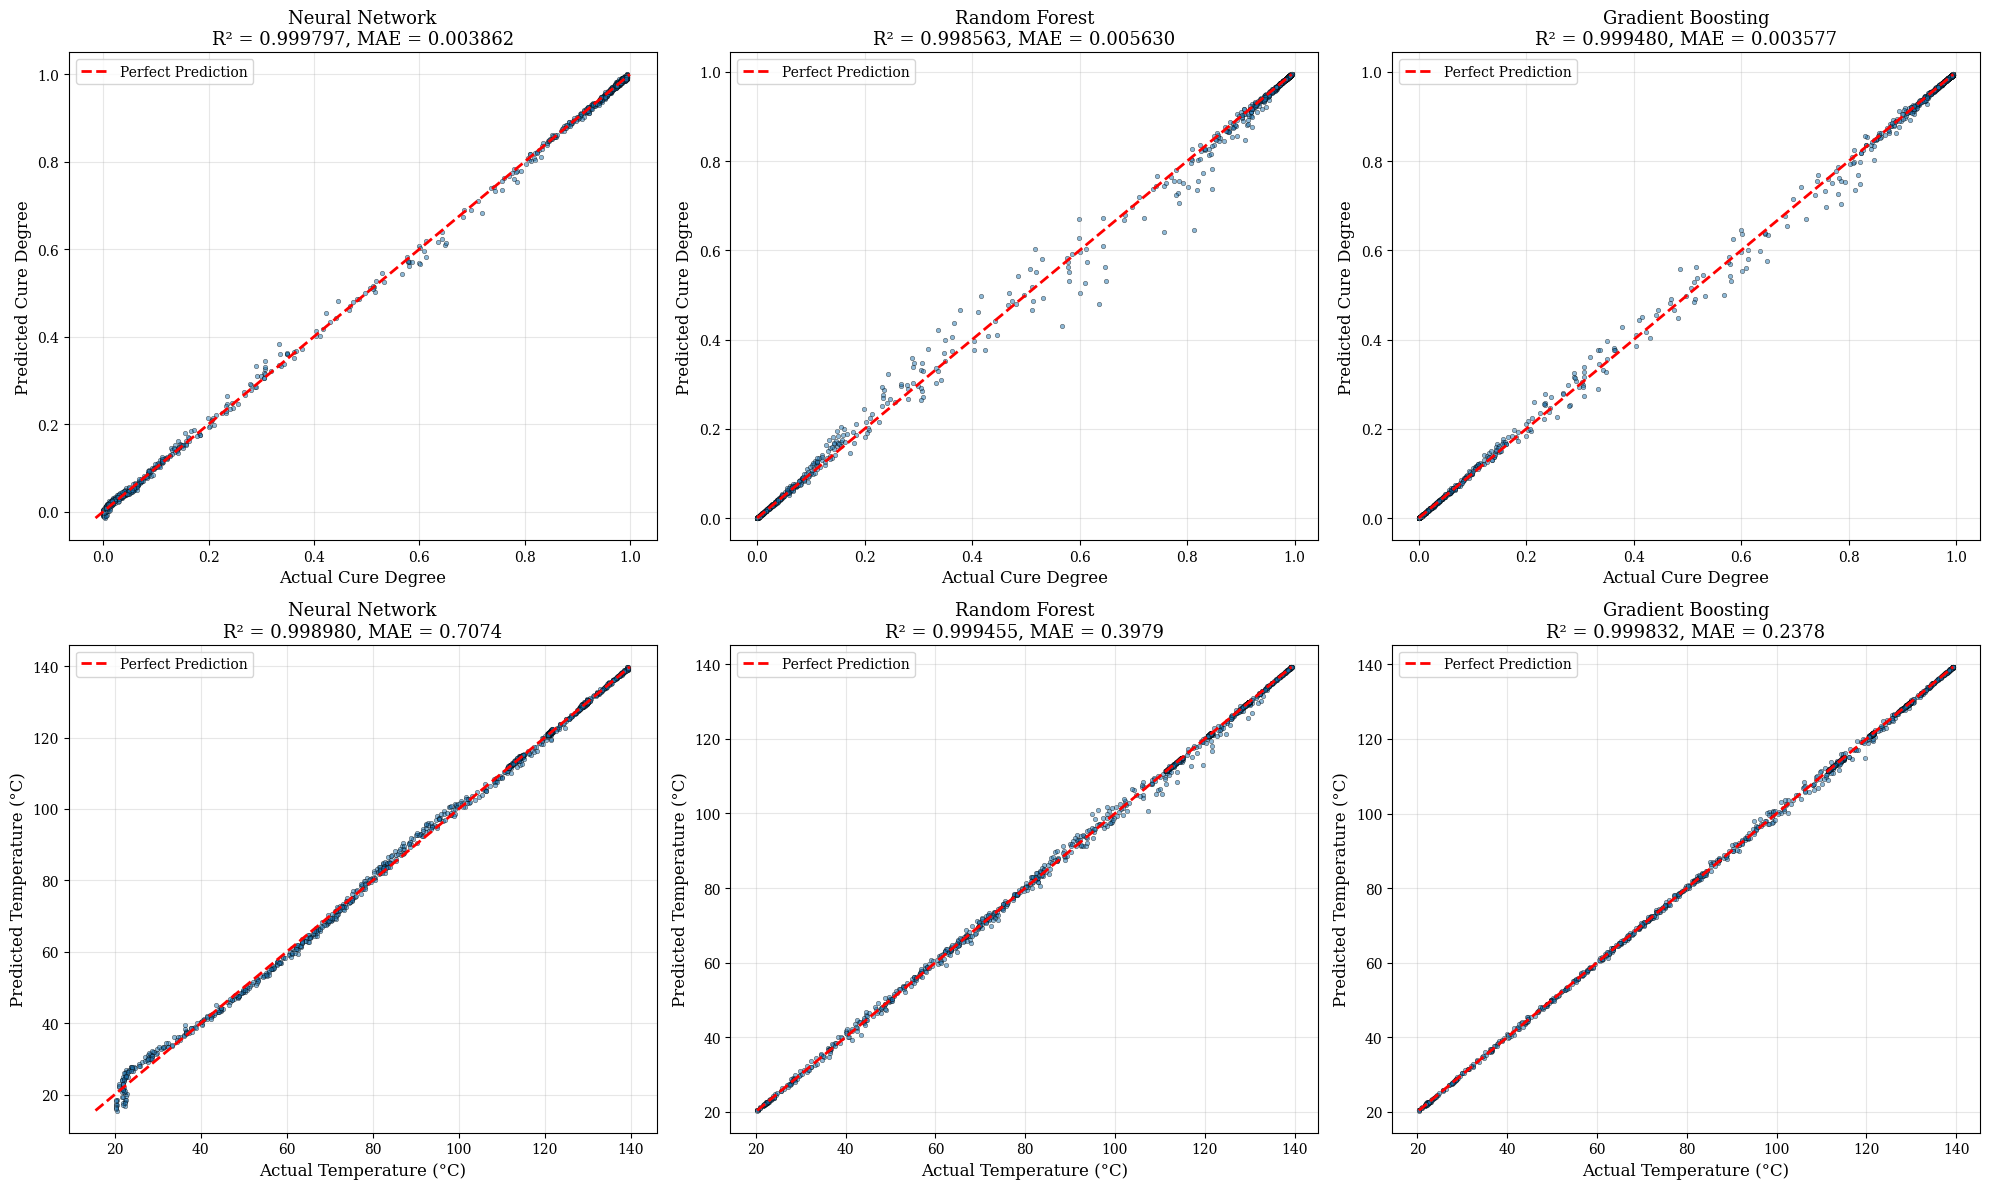

✓ Model comparison charts saved

------------------------------------------------------------
Analyzing Feature Importance...
------------------------------------------------------------

Calculating permutation importance for Neural Networks...

FEATURE IMPORTANCE ANALYSIS

📊 CURE DEGREE PREDICTION:
------------------------------------------------------------

Neural Network:
  Velocity            :  10.14%
  Die Temperature     :   1.99%
  Axial Distance      :  87.87%

Random Forest:
  Velocity            :   8.03%
  Die Temperature     :   1.91%
  Axial Distance      :  90.06%

Gradient Boosting:
  Velocity            :   8.16%
  Die Temperature     :   2.11%
  Axial Distance      :  89.73%

📊 TEMPERATURE PREDICTION:
------------------------------------------------------------

Neural Network:
  Velocity            :   5.31%
  Die Temperature     :   5.05%
  Axial Distance      :  89.63%

Random Forest:
  Velocity            :   4.17%
  Die Temperature     :   5.34%
  Axial Distanc

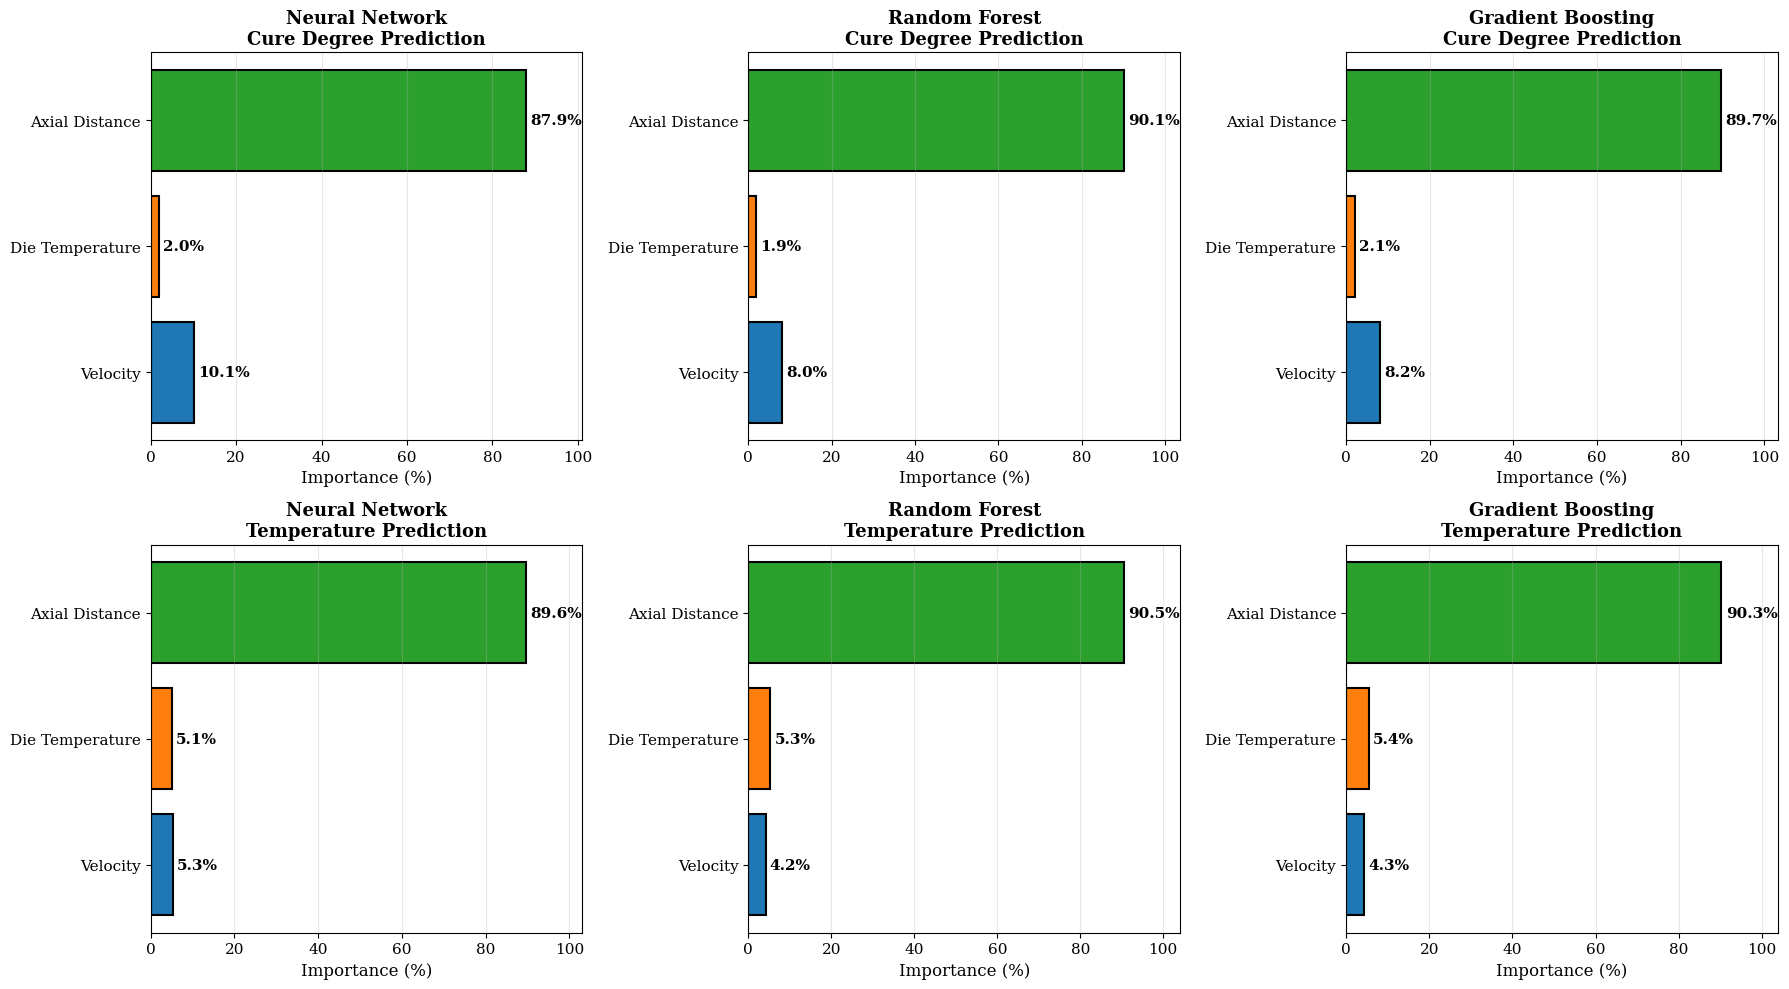


✓ Feature importance charts saved

Exporting to Excel...
Excel file 'pultrusion_results.xlsx' created successfully!

Creating high-resolution design charts for publication...


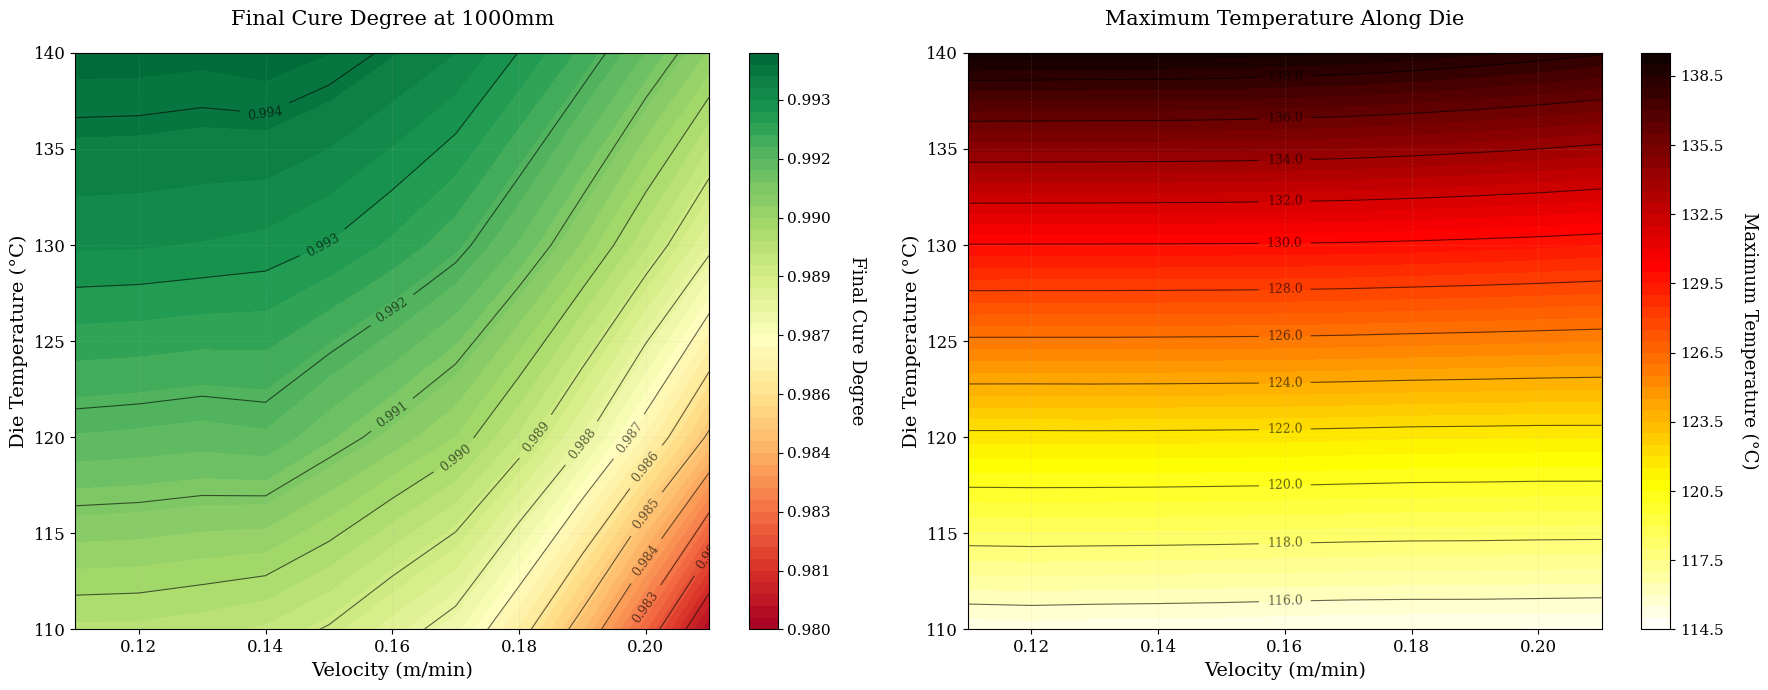

High-resolution design charts saved:
  - design_charts_publication.png (600 dpi)
  - design_charts_publication.pdf (vector)
  - design_charts_publication.eps (vector)

Creating high-resolution 3D surface plots...


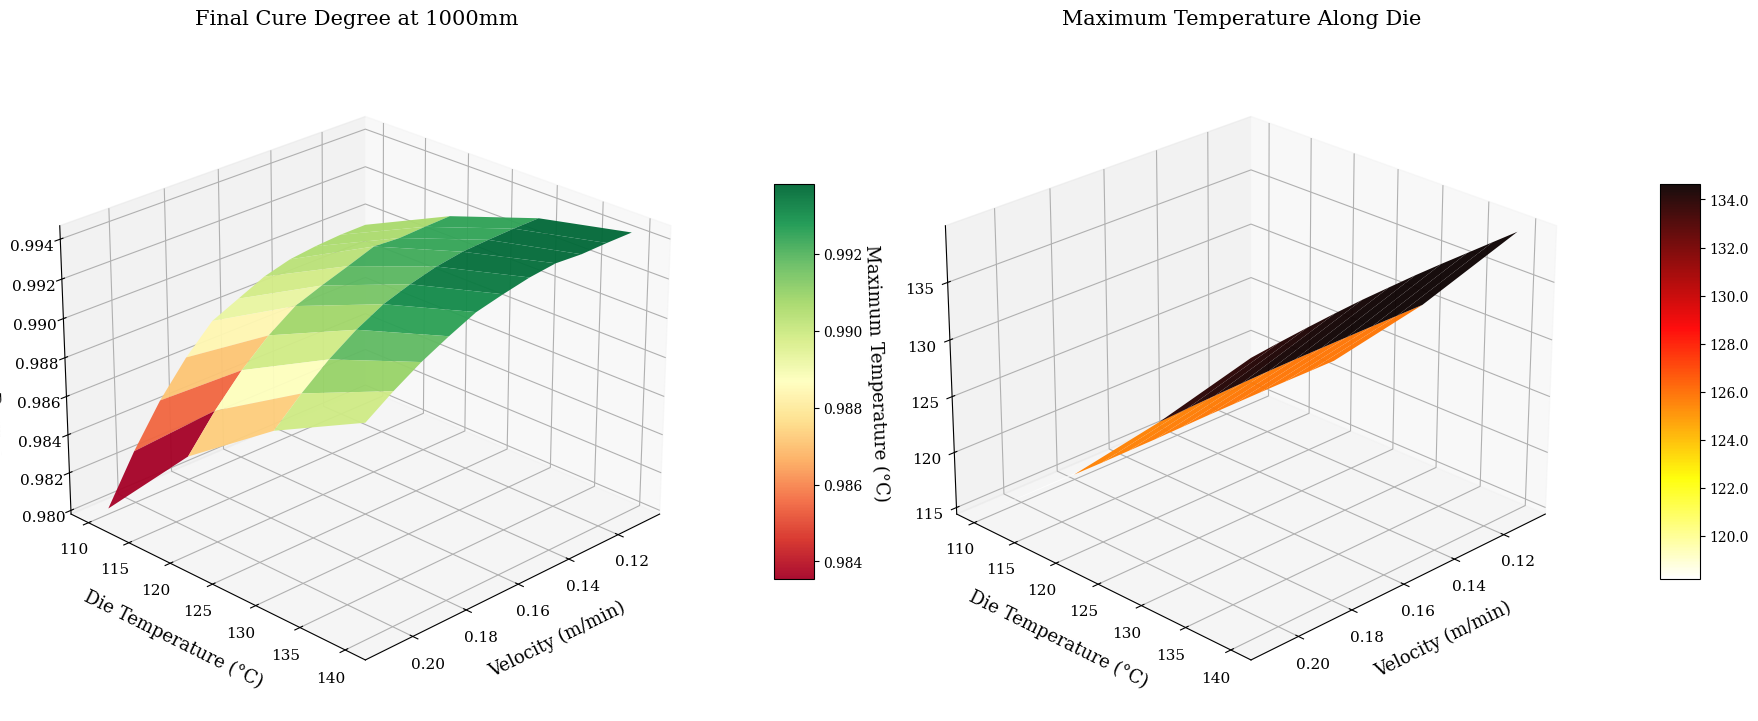

High-resolution 3D charts saved:
  - design_charts_3d_publication.png (600 dpi)
  - design_charts_3d_publication.pdf (vector)
  - design_charts_3d_publication.eps (vector)

PROCESSING COMPLETE!

Generated files:

📊 Excel File:
  • pultrusion_results.xlsx (includes ML performance & feature importance)

📈 2D Contour Plots (Publication Quality - 600 DPI):
  • design_charts_publication.png
  • design_charts_publication.pdf (vector)
  • design_charts_publication.eps (vector)

📉 3D Surface Plots (Publication Quality - 600 DPI):
  • design_charts_3d_publication.png
  • design_charts_3d_publication.pdf (vector)
  • design_charts_3d_publication.eps (vector)

🤖 ML Model Performance:
  • ml_model_comparison.png
  • ml_model_comparison.pdf (vector)
  • ml_model_comparison.eps (vector)

🎯 Feature Importance Analysis:
  • feature_importance.png
  • feature_importance.pdf (vector)
  • feature_importance.eps (vector)

💾 Trained Models:
  • models_cure.pkl (trained models)
  • models_temp.pkl (trained 

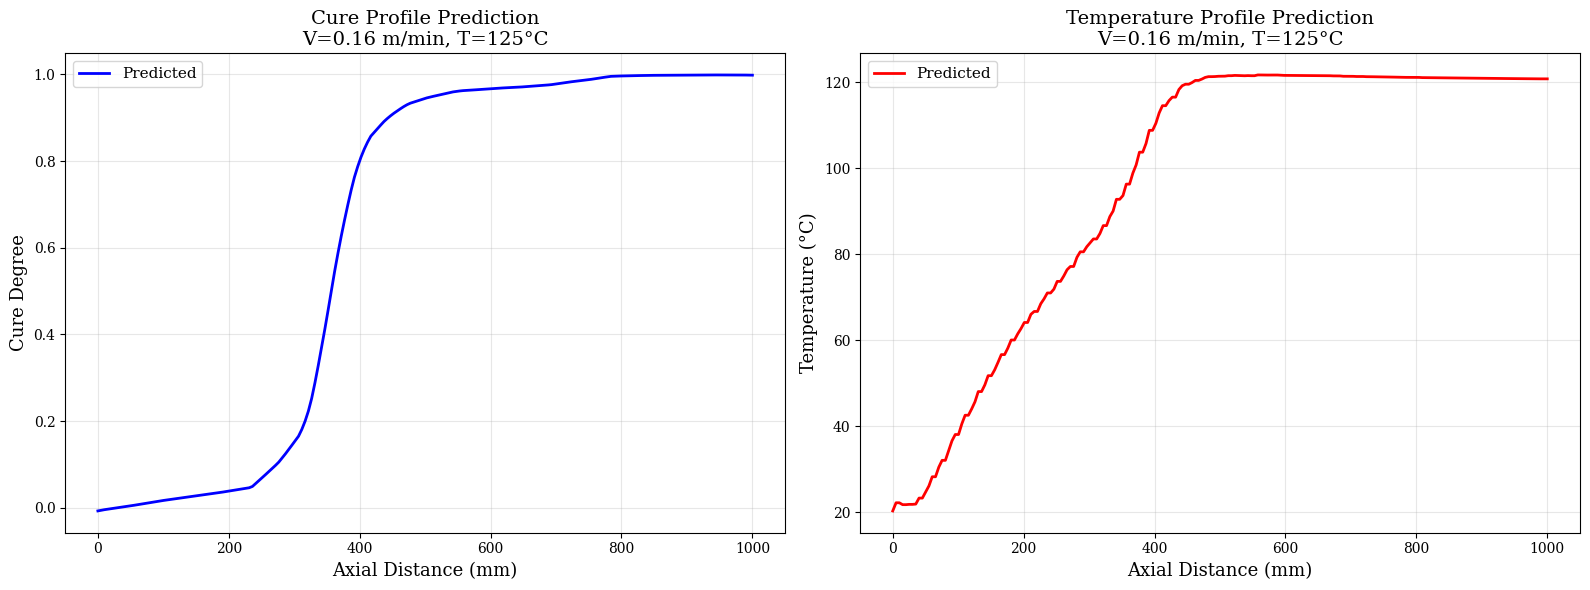

✓ Prediction example saved



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import griddata
import openpyxl
from openpyxl.styles import Font, PatternFill, Alignment
from google.colab import files
import subprocess
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance
import pickle
import warnings
warnings.filterwarnings('ignore')

# ===== INSTALL TIMES NEW ROMAN FONT =====
print("Installing Times New Roman font...")
try:
    subprocess.run(['apt-get', 'install', '-y', 'msttcorefonts', '-qq'],
                   stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    # Remove matplotlib font cache
    subprocess.run(['rm', '-rf', os.path.expanduser('~/.cache/matplotlib')],
                   stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    print("✓ Font installation complete")
except:
    print("Note: Using default serif font")

# Set font to Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif', 'Liberation Serif']
plt.rcParams['mathtext.fontset'] = 'stix'

# ===== INPUT PARAMETERS =====
print("=" * 60)
print("PULTRUSION PARAMETRIC STUDY DATA PROCESSOR")
print("=" * 60)

# Get velocity range
vel_min = float(input("\nEnter minimum velocity (m/min): "))
vel_max = float(input("Enter maximum velocity (m/min): "))
vel_step = float(input("Enter velocity step (m/min): "))

# Get temperature range
temp_min = float(input("\nEnter minimum die temperature (°C): "))
temp_max = float(input("Enter maximum die temperature (°C): "))
temp_step = float(input("Enter temperature step (°C): "))

# Generate parameter arrays
velocities = np.arange(vel_min, vel_max + vel_step/2, vel_step)
temperatures = np.arange(temp_min, temp_max + temp_step/2, temp_step)

print(f"\nVelocities: {velocities}")
print(f"Temperatures: {temperatures}")
print(f"Total number of cases: {len(velocities) * len(temperatures)}")

# ===== UPLOAD FILES =====
print("\n" + "=" * 60)
print("Please upload the 'cure' file:")
uploaded_cure = files.upload()
cure_filename = list(uploaded_cure.keys())[0]

print("\nPlease upload the 'temperature' file:")
uploaded_temp = files.upload()
temp_filename = list(uploaded_temp.keys())[0]

# ===== PROCESS CURE DATA =====
print("\n" + "=" * 60)
print("Processing cure data...")

# Read the cure file
cure_data = pd.read_csv(cure_filename, sep=r'\s+', header=None, names=['Axial_Distance', 'Cure_Degree'])

# Determine number of points per case (assuming distance goes from 0 to 1000)
axial_distances = cure_data['Axial_Distance'].values
# Find where the pattern repeats (when distance resets)
reset_indices = np.where(np.diff(axial_distances) < 0)[0] + 1
if len(reset_indices) > 0:
    points_per_case = reset_indices[0]
else:
    points_per_case = len(axial_distances)

print(f"Points per case: {points_per_case}")

# Create organized cure dataframe
cure_organized = pd.DataFrame()
cure_organized['Axial_Distance'] = axial_distances[:points_per_case]

case_idx = 0
for vel in velocities:
    for temp in temperatures:
        start_idx = case_idx * points_per_case
        end_idx = start_idx + points_per_case
        col_name = f'V={vel:.2f}_T={temp:.0f}'
        cure_organized[col_name] = cure_data['Cure_Degree'].values[start_idx:end_idx]
        case_idx += 1

# ===== PROCESS TEMPERATURE DATA =====
print("Processing temperature data...")

# Read the temperature file
temp_data = pd.read_csv(temp_filename, sep=r'\s+', header=None, names=['Axial_Distance', 'Die_Temperature'])

# Create organized temperature dataframe
temp_organized = pd.DataFrame()
temp_organized['Axial_Distance'] = axial_distances[:points_per_case]

case_idx = 0
for vel in velocities:
    for temp in temperatures:
        start_idx = case_idx * points_per_case
        end_idx = start_idx + points_per_case
        col_name = f'V={vel:.2f}_T={temp:.0f}'
        temp_organized[col_name] = temp_data['Die_Temperature'].values[start_idx:end_idx]
        case_idx += 1

# ===== CREATE SUMMARY DATAFRAME =====
print("Creating summary statistics...")

summary_data = []
for vel in velocities:
    for temp in temperatures:
        col_name = f'V={vel:.2f}_T={temp:.0f}'

        # Final cure degree at 1000mm (last value)
        final_cure = cure_organized[col_name].iloc[-1]

        # Maximum temperature along the die
        max_temp = temp_organized[col_name].max()

        summary_data.append({
            'Velocity (m/min)': vel,
            'Die Temperature (°C)': temp,
            'Final Cure Degree at 1000mm': final_cure,
            'Maximum Temperature (°C)': max_temp
        })

summary_df = pd.DataFrame(summary_data)

# ===== PREPARE ML TRAINING DATA =====
print("\n" + "=" * 60)
print("MACHINE LEARNING MODEL TRAINING")
print("=" * 60)
print("\nPreparing training data...")

# Create comprehensive dataset for ML
ml_data = []
for vel in velocities:
    for temp in temperatures:
        col_name = f'V={vel:.2f}_T={temp:.0f}'

        # Get all axial distances and corresponding values
        for idx in range(len(cure_organized)):
            axial_dist = cure_organized['Axial_Distance'].iloc[idx]
            cure_value = cure_organized[col_name].iloc[idx]
            temp_value = temp_organized[col_name].iloc[idx]

            ml_data.append({
                'Velocity': vel,
                'Die_Temperature': temp,
                'Axial_Distance': axial_dist,
                'Cure_Degree': cure_value,
                'Temperature': temp_value
            })

ml_df = pd.DataFrame(ml_data)

# Prepare features and targets
X = ml_df[['Velocity', 'Die_Temperature', 'Axial_Distance']].values
y_cure = ml_df['Cure_Degree'].values
y_temp = ml_df['Temperature'].values

# Split data (80% train, 20% test)
X_train, X_test, y_cure_train, y_cure_test, y_temp_train, y_temp_test = train_test_split(
    X, y_cure, y_temp, test_size=0.2, random_state=42
)

# Standardize features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Standardize targets for better neural network training
scaler_cure = StandardScaler()
scaler_temp = StandardScaler()
y_cure_train_scaled = scaler_cure.fit_transform(y_cure_train.reshape(-1, 1)).ravel()
y_temp_train_scaled = scaler_temp.fit_transform(y_temp_train.reshape(-1, 1)).ravel()

print(f"✓ Training samples: {len(X_train)}")
print(f"✓ Testing samples: {len(X_test)}")

# ===== TRAIN MODELS FOR CURE DEGREE =====
print("\n" + "-" * 60)
print("Training Cure Degree Prediction Models...")
print("-" * 60)

models_cure = {}

# 1. Neural Network
print("\n1. Neural Network (MLP)...")
nn_cure = MLPRegressor(hidden_layer_sizes=(100, 100, 50), activation='relu',
                       solver='adam', max_iter=1000, random_state=42,
                       early_stopping=True, validation_fraction=0.1)
nn_cure.fit(X_train_scaled, y_cure_train_scaled)
y_cure_pred_nn_scaled = nn_cure.predict(X_test_scaled)
y_cure_pred_nn = scaler_cure.inverse_transform(y_cure_pred_nn_scaled.reshape(-1, 1)).ravel()
models_cure['Neural Network'] = (nn_cure, scaler_X, scaler_cure)

r2_nn = r2_score(y_cure_test, y_cure_pred_nn)
mse_nn = mean_squared_error(y_cure_test, y_cure_pred_nn)
mae_nn = mean_absolute_error(y_cure_test, y_cure_pred_nn)
print(f"   R² = {r2_nn:.6f}, MSE = {mse_nn:.8f}, MAE = {mae_nn:.8f}")

# 2. Random Forest
print("\n2. Random Forest...")
rf_cure = RandomForestRegressor(n_estimators=200, max_depth=20,
                                random_state=42, n_jobs=-1)
rf_cure.fit(X_train, y_cure_train)
y_cure_pred_rf = rf_cure.predict(X_test)
models_cure['Random Forest'] = (rf_cure, None, None)

r2_rf = r2_score(y_cure_test, y_cure_pred_rf)
mse_rf = mean_squared_error(y_cure_test, y_cure_pred_rf)
mae_rf = mean_absolute_error(y_cure_test, y_cure_pred_rf)
print(f"   R² = {r2_rf:.6f}, MSE = {mse_rf:.8f}, MAE = {mae_rf:.8f}")

# 3. Gradient Boosting
print("\n3. Gradient Boosting...")
gb_cure = GradientBoostingRegressor(n_estimators=200, max_depth=7,
                                    learning_rate=0.1, random_state=42)
gb_cure.fit(X_train, y_cure_train)
y_cure_pred_gb = gb_cure.predict(X_test)
models_cure['Gradient Boosting'] = (gb_cure, None, None)

r2_gb = r2_score(y_cure_test, y_cure_pred_gb)
mse_gb = mean_squared_error(y_cure_test, y_cure_pred_gb)
mae_gb = mean_absolute_error(y_cure_test, y_cure_pred_gb)
print(f"   R² = {r2_gb:.6f}, MSE = {mse_gb:.8f}, MAE = {mae_gb:.8f}")

# ===== TRAIN MODELS FOR TEMPERATURE =====
print("\n" + "-" * 60)
print("Training Temperature Prediction Models...")
print("-" * 60)

models_temp = {}

# 1. Neural Network
print("\n1. Neural Network (MLP)...")
nn_temp = MLPRegressor(hidden_layer_sizes=(100, 100, 50), activation='relu',
                       solver='adam', max_iter=1000, random_state=42,
                       early_stopping=True, validation_fraction=0.1)
nn_temp.fit(X_train_scaled, y_temp_train_scaled)
y_temp_pred_nn_scaled = nn_temp.predict(X_test_scaled)
y_temp_pred_nn = scaler_temp.inverse_transform(y_temp_pred_nn_scaled.reshape(-1, 1)).ravel()
models_temp['Neural Network'] = (nn_temp, scaler_X, scaler_temp)

r2_nn_t = r2_score(y_temp_test, y_temp_pred_nn)
mse_nn_t = mean_squared_error(y_temp_test, y_temp_pred_nn)
mae_nn_t = mean_absolute_error(y_temp_test, y_temp_pred_nn)
print(f"   R² = {r2_nn_t:.6f}, MSE = {mse_nn_t:.8f}, MAE = {mae_nn_t:.8f}")

# 2. Random Forest
print("\n2. Random Forest...")
rf_temp = RandomForestRegressor(n_estimators=200, max_depth=20,
                                random_state=42, n_jobs=-1)
rf_temp.fit(X_train, y_temp_train)
y_temp_pred_rf = rf_temp.predict(X_test)
models_temp['Random Forest'] = (rf_temp, None, None)

r2_rf_t = r2_score(y_temp_test, y_temp_pred_rf)
mse_rf_t = mean_squared_error(y_temp_test, y_temp_pred_rf)
mae_rf_t = mean_absolute_error(y_temp_test, y_temp_pred_rf)
print(f"   R² = {r2_rf_t:.6f}, MSE = {mse_rf_t:.8f}, MAE = {mae_rf_t:.8f}")

# 3. Gradient Boosting
print("\n3. Gradient Boosting...")
gb_temp = GradientBoostingRegressor(n_estimators=200, max_depth=7,
                                    learning_rate=0.1, random_state=42)
gb_temp.fit(X_train, y_temp_train)
y_temp_pred_gb = gb_temp.predict(X_test)
models_temp['Gradient Boosting'] = (gb_temp, None, None)

r2_gb_t = r2_score(y_temp_test, y_temp_pred_gb)
mse_gb_t = mean_squared_error(y_temp_test, y_temp_pred_gb)
mae_gb_t = mean_absolute_error(y_temp_test, y_temp_pred_gb)
print(f"   R² = {r2_gb_t:.6f}, MSE = {mse_gb_t:.8f}, MAE = {mae_gb_t:.8f}")

# ===== SAVE BEST MODELS =====
print("\n" + "-" * 60)
print("Saving trained models...")

# Determine best models based on R²
cure_performances = {'Neural Network': r2_nn, 'Random Forest': r2_rf, 'Gradient Boosting': r2_gb}
temp_performances = {'Neural Network': r2_nn_t, 'Random Forest': r2_rf_t, 'Gradient Boosting': r2_gb_t}

best_cure_model_name = max(cure_performances, key=cure_performances.get)
best_temp_model_name = max(temp_performances, key=temp_performances.get)

print(f"✓ Best Cure Model: {best_cure_model_name} (R² = {cure_performances[best_cure_model_name]:.6f})")
print(f"✓ Best Temperature Model: {best_temp_model_name} (R² = {temp_performances[best_temp_model_name]:.6f})")

# Save all models
with open('models_cure.pkl', 'wb') as f:
    pickle.dump(models_cure, f)

with open('models_temp.pkl', 'wb') as f:
    pickle.dump(models_temp, f)

print("✓ Models saved as 'models_cure.pkl' and 'models_temp.pkl'")

# ===== CREATE MODEL PERFORMANCE COMPARISON CHARTS =====
print("\nCreating model performance comparison charts...")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Cure Degree Models
predictions_cure = {
    'Neural Network': y_cure_pred_nn,
    'Random Forest': y_cure_pred_rf,
    'Gradient Boosting': y_cure_pred_gb
}

for idx, (model_name, y_pred) in enumerate(predictions_cure.items()):
    ax = axes[0, idx]
    ax.scatter(y_cure_test, y_pred, alpha=0.5, s=10, edgecolors='k', linewidths=0.5)

    # Perfect prediction line
    min_val = min(y_cure_test.min(), y_pred.min())
    max_val = max(y_cure_test.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

    r2 = r2_score(y_cure_test, y_pred)
    mae = mean_absolute_error(y_cure_test, y_pred)

    ax.set_xlabel('Actual Cure Degree', fontsize=12)
    ax.set_ylabel('Predicted Cure Degree', fontsize=12)
    ax.set_title(f'{model_name}\nR² = {r2:.6f}, MAE = {mae:.6f}', fontsize=13)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

# Temperature Models
predictions_temp = {
    'Neural Network': y_temp_pred_nn,
    'Random Forest': y_temp_pred_rf,
    'Gradient Boosting': y_temp_pred_gb
}

for idx, (model_name, y_pred) in enumerate(predictions_temp.items()):
    ax = axes[1, idx]
    ax.scatter(y_temp_test, y_pred, alpha=0.5, s=10, edgecolors='k', linewidths=0.5)

    # Perfect prediction line
    min_val = min(y_temp_test.min(), y_pred.min())
    max_val = max(y_temp_test.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

    r2 = r2_score(y_temp_test, y_pred)
    mae = mean_absolute_error(y_temp_test, y_pred)

    ax.set_xlabel('Actual Temperature (°C)', fontsize=12)
    ax.set_ylabel('Predicted Temperature (°C)', fontsize=12)
    ax.set_title(f'{model_name}\nR² = {r2:.6f}, MAE = {mae:.4f}', fontsize=13)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ml_model_comparison.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('ml_model_comparison.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('ml_model_comparison.eps', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Model comparison charts saved")

# ===== FEATURE IMPORTANCE ANALYSIS =====
print("\n" + "-" * 60)
print("Analyzing Feature Importance...")
print("-" * 60)

feature_names = ['Velocity', 'Die Temperature', 'Axial Distance']

# Extract feature importance from tree-based models
# For Cure Degree
rf_cure_importance = rf_cure.feature_importances_
gb_cure_importance = gb_cure.feature_importances_

# For Temperature
rf_temp_importance = rf_temp.feature_importances_
gb_temp_importance = gb_temp.feature_importances_

# Calculate permutation importance for Neural Networks

print("\nCalculating permutation importance for Neural Networks...")
nn_cure_perm = permutation_importance(nn_cure, X_test_scaled,
                                      scaler_cure.transform(y_cure_test.reshape(-1, 1)).ravel(),
                                      n_repeats=10, random_state=42, n_jobs=-1)
nn_temp_perm = permutation_importance(nn_temp, X_test_scaled,
                                      scaler_temp.transform(y_temp_test.reshape(-1, 1)).ravel(),
                                      n_repeats=10, random_state=42, n_jobs=-1)

nn_cure_importance = nn_cure_perm.importances_mean
nn_temp_importance = nn_temp_perm.importances_mean

# Normalize to percentages
nn_cure_importance = nn_cure_importance / nn_cure_importance.sum() * 100
nn_temp_importance = nn_temp_importance / nn_temp_importance.sum() * 100
rf_cure_importance = rf_cure_importance / rf_cure_importance.sum() * 100
gb_cure_importance = gb_cure_importance / gb_cure_importance.sum() * 100
rf_temp_importance = rf_temp_importance / rf_temp_importance.sum() * 100
gb_temp_importance = gb_temp_importance / gb_temp_importance.sum() * 100

# Print feature importance
print("\n" + "=" * 60)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

print("\n📊 CURE DEGREE PREDICTION:")
print("-" * 60)
for model_name, importance in [('Neural Network', nn_cure_importance),
                                ('Random Forest', rf_cure_importance),
                                ('Gradient Boosting', gb_cure_importance)]:
    print(f"\n{model_name}:")
    for feat, imp in zip(feature_names, importance):
        print(f"  {feat:20s}: {imp:6.2f}%")

print("\n📊 TEMPERATURE PREDICTION:")
print("-" * 60)
for model_name, importance in [('Neural Network', nn_temp_importance),
                                ('Random Forest', rf_temp_importance),
                                ('Gradient Boosting', gb_temp_importance)]:
    print(f"\n{model_name}:")
    for feat, imp in zip(feature_names, importance):
        print(f"  {feat:20s}: {imp:6.2f}%")

# Create feature importance visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Cure Degree Feature Importance
importance_data_cure = {
    'Neural Network': nn_cure_importance,
    'Random Forest': rf_cure_importance,
    'Gradient Boosting': gb_cure_importance
}

for idx, (model_name, importance) in enumerate(importance_data_cure.items()):
    ax = axes[0, idx]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    bars = ax.barh(feature_names, importance, color=colors, edgecolor='black', linewidth=1.5)

    # Add percentage labels
    for bar, imp in zip(bars, importance):
        width = bar.get_width()
        ax.text(width + 1, bar.get_y() + bar.get_height()/2,
                f'{imp:.1f}%', ha='left', va='center', fontsize=11, fontweight='bold')

    ax.set_xlabel('Importance (%)', fontsize=12)
    ax.set_title(f'{model_name}\nCure Degree Prediction', fontsize=13, fontweight='bold')
    ax.set_xlim(0, max(importance) * 1.15)
    ax.grid(axis='x', alpha=0.3)
    ax.tick_params(axis='both', labelsize=11)

# Temperature Feature Importance
importance_data_temp = {
    'Neural Network': nn_temp_importance,
    'Random Forest': rf_temp_importance,
    'Gradient Boosting': gb_temp_importance
}

for idx, (model_name, importance) in enumerate(importance_data_temp.items()):
    ax = axes[1, idx]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    bars = ax.barh(feature_names, importance, color=colors, edgecolor='black', linewidth=1.5)

    # Add percentage labels
    for bar, imp in zip(bars, importance):
        width = bar.get_width()
        ax.text(width + 1, bar.get_y() + bar.get_height()/2,
                f'{imp:.1f}%', ha='left', va='center', fontsize=11, fontweight='bold')

    ax.set_xlabel('Importance (%)', fontsize=12)
    ax.set_title(f'{model_name}\nTemperature Prediction', fontsize=13, fontweight='bold')
    ax.set_xlim(0, max(importance) * 1.15)
    ax.grid(axis='x', alpha=0.3)
    ax.tick_params(axis='both', labelsize=11)

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('feature_importance.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('feature_importance.eps', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print("\n✓ Feature importance charts saved")

# Create feature importance summary dataframe
feature_importance_summary = []
for feat_idx, feat_name in enumerate(feature_names):
    feature_importance_summary.append({
        'Feature': feat_name,
        'NN_Cure (%)': nn_cure_importance[feat_idx],
        'RF_Cure (%)': rf_cure_importance[feat_idx],
        'GB_Cure (%)': gb_cure_importance[feat_idx],
        'Avg_Cure (%)': np.mean([nn_cure_importance[feat_idx],
                                  rf_cure_importance[feat_idx],
                                  gb_cure_importance[feat_idx]]),
        'NN_Temp (%)': nn_temp_importance[feat_idx],
        'RF_Temp (%)': rf_temp_importance[feat_idx],
        'GB_Temp (%)': gb_temp_importance[feat_idx],
        'Avg_Temp (%)': np.mean([nn_temp_importance[feat_idx],
                                  rf_temp_importance[feat_idx],
                                  gb_temp_importance[feat_idx]])
    })

feature_importance_df = pd.DataFrame(feature_importance_summary)

# ===== CREATE MODEL PERFORMANCE SUMMARY TABLE =====
performance_data = []

for model_name in ['Neural Network', 'Random Forest', 'Gradient Boosting']:
    if model_name == 'Neural Network':
        cure_pred = y_cure_pred_nn
        temp_pred = y_temp_pred_nn
    elif model_name == 'Random Forest':
        cure_pred = y_cure_pred_rf
        temp_pred = y_temp_pred_rf
    else:
        cure_pred = y_cure_pred_gb
        temp_pred = y_temp_pred_gb

    performance_data.append({
        'Model': model_name,
        'Cure R²': r2_score(y_cure_test, cure_pred),
        'Cure MSE': mean_squared_error(y_cure_test, cure_pred),
        'Cure MAE': mean_absolute_error(y_cure_test, cure_pred),
        'Temp R²': r2_score(y_temp_test, temp_pred),
        'Temp MSE': mean_squared_error(y_temp_test, temp_pred),
        'Temp MAE': mean_absolute_error(y_temp_test, temp_pred)
    })

performance_df = pd.DataFrame(performance_data)

print("\n" + "=" * 60)

# ===== EXPORT TO EXCEL =====
print("Exporting to Excel...")

with pd.ExcelWriter('pultrusion_results.xlsx', engine='openpyxl') as writer:
    # Sheet 1: Summary
    summary_df.to_excel(writer, sheet_name='Summary', index=False)

    # Sheet 2: ML Model Performance
    performance_df.to_excel(writer, sheet_name='ML_Model_Performance', index=False)

    # Sheet 3: Feature Importance
    feature_importance_df.to_excel(writer, sheet_name='Feature_Importance', index=False)

    # Sheet 4: Cure Data
    cure_organized.to_excel(writer, sheet_name='Cure_Degree', index=False)

    # Sheet 5: Temperature Data
    temp_organized.to_excel(writer, sheet_name='Die_Temperature', index=False)

# Format the Excel file
wb = openpyxl.load_workbook('pultrusion_results.xlsx')
ws_summary = wb['Summary']

# Format headers
header_fill = PatternFill(start_color='366092', end_color='366092', fill_type='solid')
header_font = Font(bold=True, color='FFFFFF')

for cell in ws_summary[1]:
    cell.fill = header_fill
    cell.font = header_font
    cell.alignment = Alignment(horizontal='center', vertical='center')

# Auto-adjust column widths
for column in ws_summary.columns:
    max_length = 0
    column = [cell for cell in column]
    for cell in column:
        try:
            if len(str(cell.value)) > max_length:
                max_length = len(cell.value)
        except:
            pass
    adjusted_width = (max_length + 2)
    ws_summary.column_dimensions[column[0].column_letter].width = adjusted_width

wb.save('pultrusion_results.xlsx')

print("Excel file 'pultrusion_results.xlsx' created successfully!")

# ===== CREATE DESIGN CHARTS =====
print("\nCreating high-resolution design charts for publication...")

# Prepare data for contour plots
vel_grid, temp_grid = np.meshgrid(velocities, temperatures)

# Reshape data for plotting
cure_matrix = summary_df['Final Cure Degree at 1000mm'].values.reshape(len(velocities), len(temperatures)).T
temp_max_matrix = summary_df['Maximum Temperature (°C)'].values.reshape(len(velocities), len(temperatures)).T

# Determine contour levels for cure degree (0.001 step)
cure_min = cure_matrix.min()
cure_max = cure_matrix.max()
cure_levels_contour = np.arange(np.floor(cure_min * 1000) / 1000,
                                 np.ceil(cure_max * 1000) / 1000 + 0.001,
                                 0.001)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Final Cure Degree
contour1 = ax1.contourf(vel_grid, temp_grid, cure_matrix, levels=50, cmap='RdYlGn')
contour1_lines = ax1.contour(vel_grid, temp_grid, cure_matrix, levels=cure_levels_contour,
                              colors='black', linewidths=0.8, alpha=0.6)
ax1.clabel(contour1_lines, inline=True, fontsize=9, fmt='%.3f', inline_spacing=8)
cbar1 = plt.colorbar(contour1, ax=ax1, format='%.3f')
cbar1.set_label('Final Cure Degree', rotation=270, labelpad=25, fontsize=13)
cbar1.ax.tick_params(labelsize=11)
ax1.set_xlabel('Velocity (m/min)', fontsize=14)
ax1.set_ylabel('Die Temperature (°C)', fontsize=14)
ax1.set_title('Final Cure Degree at 1000mm', fontsize=15, pad=20)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)

# Plot 2: Maximum Temperature
contour2 = ax2.contourf(vel_grid, temp_grid, temp_max_matrix, levels=50, cmap='hot_r')
contour2_lines = ax2.contour(vel_grid, temp_grid, temp_max_matrix, levels=15,
                              colors='black', linewidths=0.8, alpha=0.6)
ax2.clabel(contour2_lines, inline=True, fontsize=9, fmt='%.1f', inline_spacing=8)
cbar2 = plt.colorbar(contour2, ax=ax2, format='%.1f')
cbar2.set_label('Maximum Temperature (°C)', rotation=270, labelpad=25, fontsize=13)
cbar2.ax.tick_params(labelsize=11)
ax2.set_xlabel('Velocity (m/min)', fontsize=14)
ax2.set_ylabel('Die Temperature (°C)', fontsize=14)
ax2.set_title('Maximum Temperature Along Die', fontsize=15, pad=20)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('design_charts_publication.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('design_charts_publication.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('design_charts_publication.eps', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print("High-resolution design charts saved:")
print("  - design_charts_publication.png (600 dpi)")
print("  - design_charts_publication.pdf (vector)")
print("  - design_charts_publication.eps (vector)")

# ===== CREATE 3D SURFACE PLOTS =====
print("\nCreating high-resolution 3D surface plots...")

fig = plt.figure(figsize=(18, 7))

# 3D plot 1: Final Cure Degree
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(vel_grid, temp_grid, cure_matrix, cmap='RdYlGn',
                          edgecolor='none', alpha=0.95, antialiased=True,
                          linewidth=0, shade=True)
ax1.set_xlabel('Velocity (m/min)', fontsize=13, labelpad=10)
ax1.set_ylabel('Die Temperature (°C)', fontsize=13, labelpad=10)
ax1.set_zlabel('Final Cure Degree', fontsize=13, labelpad=10)
ax1.set_title('Final Cure Degree at 1000mm', fontsize=15, pad=20)
ax1.tick_params(axis='both', which='major', labelsize=11)
ax1.view_init(elev=25, azim=45)
cbar1 = fig.colorbar(surf1, ax=ax1, shrink=0.6, aspect=10, pad=0.1, format='%.3f')
cbar1.ax.tick_params(labelsize=10)

# 3D plot 2: Maximum Temperature
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(vel_grid, temp_grid, temp_max_matrix, cmap='hot_r',
                          edgecolor='none', alpha=0.95, antialiased=True,
                          linewidth=0, shade=True)
ax2.set_xlabel('Velocity (m/min)', fontsize=13, labelpad=10)
ax2.set_ylabel('Die Temperature (°C)', fontsize=13, labelpad=10)
ax2.set_zlabel('Maximum Temperature (°C)', fontsize=13, labelpad=10)
ax2.set_title('Maximum Temperature Along Die', fontsize=15, pad=20)
ax2.tick_params(axis='both', which='major', labelsize=11)
ax2.view_init(elev=25, azim=45)
cbar2 = fig.colorbar(surf2, ax=ax2, shrink=0.6, aspect=10, pad=0.1, format='%.1f')
cbar2.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.savefig('design_charts_3d_publication.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('design_charts_3d_publication.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('design_charts_3d_publication.eps', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print("High-resolution 3D charts saved:")
print("  - design_charts_3d_publication.png (600 dpi)")
print("  - design_charts_3d_publication.pdf (vector)")
print("  - design_charts_3d_publication.eps (vector)")

# ===== SUMMARY =====
print("\n" + "=" * 60)
print("PROCESSING COMPLETE!")
print("=" * 60)
print("\nGenerated files:")
print("\n📊 Excel File:")
print("  • pultrusion_results.xlsx (includes ML performance & feature importance)")
print("\n📈 2D Contour Plots (Publication Quality - 600 DPI):")
print("  • design_charts_publication.png")
print("  • design_charts_publication.pdf (vector)")
print("  • design_charts_publication.eps (vector)")
print("\n📉 3D Surface Plots (Publication Quality - 600 DPI):")
print("  • design_charts_3d_publication.png")
print("  • design_charts_3d_publication.pdf (vector)")
print("  • design_charts_3d_publication.eps (vector)")
print("\n🤖 ML Model Performance:")
print("  • ml_model_comparison.png")
print("  • ml_model_comparison.pdf (vector)")
print("  • ml_model_comparison.eps (vector)")
print("\n🎯 Feature Importance Analysis:")
print("  • feature_importance.png")
print("  • feature_importance.pdf (vector)")
print("  • feature_importance.eps (vector)")
print("\n💾 Trained Models:")
print("  • models_cure.pkl (trained models)")
print("  • models_temp.pkl (trained models)")
print("\n" + "=" * 60)
print("Files are ready in your Colab environment.")
print("Access them from the Files panel on the left.")
print("PDF and EPS formats are vector graphics, ideal for journals.")
print("=" * 60)

# ===== PREDICTION FUNCTION =====
def predict_pultrusion(velocity, die_temperature, axial_distance,
                       cure_model_name='best', temp_model_name='best'):
    """
    Predict cure degree and temperature for given operating conditions.

    Parameters:
    -----------
    velocity : float
        Pulling velocity in m/min
    die_temperature : float
        Die temperature in °C
    axial_distance : float or array-like
        Axial distance(s) in mm
    cure_model_name : str
        Model to use: 'Neural Network', 'Random Forest', 'Gradient Boosting', or 'best'
    temp_model_name : str
        Model to use: 'Neural Network', 'Random Forest', 'Gradient Boosting', or 'best'

    Returns:
    --------
    cure_prediction : float or array
        Predicted cure degree
    temp_prediction : float or array
        Predicted temperature in °C
    """

    # Use best models if specified
    if cure_model_name == 'best':
        cure_model_name = best_cure_model_name
    if temp_model_name == 'best':
        temp_model_name = best_temp_model_name

    # Prepare input
    if np.isscalar(axial_distance):
        X_input = np.array([[velocity, die_temperature, axial_distance]])
    else:
        X_input = np.array([[velocity, die_temperature, d] for d in axial_distance])

    # Get models
    cure_model, cure_scaler_X, cure_scaler_y = models_cure[cure_model_name]
    temp_model, temp_scaler_X, temp_scaler_y = models_temp[temp_model_name]

    # Predict cure degree
    if cure_scaler_X is not None:
        X_scaled = cure_scaler_X.transform(X_input)
        cure_pred_scaled = cure_model.predict(X_scaled)
        cure_prediction = cure_scaler_y.inverse_transform(cure_pred_scaled.reshape(-1, 1)).ravel()
    else:
        cure_prediction = cure_model.predict(X_input)

    # Predict temperature
    if temp_scaler_X is not None:
        X_scaled = temp_scaler_X.transform(X_input)
        temp_pred_scaled = temp_model.predict(X_scaled)
        temp_prediction = temp_scaler_y.inverse_transform(temp_pred_scaled.reshape(-1, 1)).ravel()
    else:
        temp_prediction = temp_model.predict(X_input)

    if np.isscalar(axial_distance):
        return cure_prediction[0], temp_prediction[0]
    else:
        return cure_prediction, temp_prediction

print("\n" + "=" * 60)
print("INTERACTIVE PREDICTION TOOL")
print("=" * 60)
print("\nYou can now make predictions using the trained models!")
print("Use the predict_pultrusion() function:")
print("\nExample usage:")
print("  cure, temp = predict_pultrusion(velocity=0.15, die_temperature=125, axial_distance=500)")
print("  print(f'Predicted Cure: {cure:.4f}, Temperature: {temp:.2f}°C')")
print("\nFor multiple axial distances:")
print("  distances = np.linspace(0, 1000, 100)")
print("  cure_profile, temp_profile = predict_pultrusion(0.15, 125, distances)")
print("\nYou can specify which model to use:")
print("  cure, temp = predict_pultrusion(0.15, 125, 500, ")
print("                                  cure_model_name='Neural Network',")
print("                                  temp_model_name='Random Forest')")
print("\n" + "=" * 60)

# ===== INTERACTIVE PREDICTION DEMO =====
print("\n" + "=" * 60)
print("DEMONSTRATION: Prediction Example")
print("=" * 60)

demo_vel = (velocities[0] + velocities[-1]) / 2
demo_temp = (temperatures[0] + temperatures[-1]) / 2
demo_dist = 500

cure_pred, temp_pred = predict_pultrusion(demo_vel, demo_temp, demo_dist)

print(f"\nInput Conditions:")
print(f"  Velocity: {demo_vel:.2f} m/min")
print(f"  Die Temperature: {demo_temp:.0f}°C")
print(f"  Axial Distance: {demo_dist:.0f} mm")
print(f"\nPredicted Results (using best models):")
print(f"  Cure Degree: {cure_pred:.6f}")
print(f"  Temperature: {temp_pred:.2f}°C")

# Create prediction profile plot
print("\nCreating prediction profile example...")
distances_demo = np.linspace(0, 1000, 200)
cure_profile, temp_profile = predict_pultrusion(demo_vel, demo_temp, distances_demo)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(distances_demo, cure_profile, 'b-', linewidth=2, label='Predicted')
ax1.set_xlabel('Axial Distance (mm)', fontsize=13)
ax1.set_ylabel('Cure Degree', fontsize=13)
ax1.set_title(f'Cure Profile Prediction\nV={demo_vel:.2f} m/min, T={demo_temp:.0f}°C', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)

ax2.plot(distances_demo, temp_profile, 'r-', linewidth=2, label='Predicted')
ax2.set_xlabel('Axial Distance (mm)', fontsize=13)
ax2.set_ylabel('Temperature (°C)', fontsize=13)
ax2.set_title(f'Temperature Profile Prediction\nV={demo_vel:.2f} m/min, T={demo_temp:.0f}°C', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)

plt.tight_layout()
plt.savefig('prediction_example.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('prediction_example.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Prediction example saved")
print("\n" + "=" * 60)

File downloading

In [ ]:
!rm -rf ./*


In [ ]:
!zip -r profile_50_2_AI.zip /content/
from google.colab import files
files.download('profile_50_2_AI.zip')


  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2025.10.17/ (stored 0%)
  adding: content/.config/logs/2025.10.17/22.28.55.279765.log (deflated 58%)
  adding: content/.config/logs/2025.10.17/22.28.53.634331.log (deflated 86%)
  adding: content/.config/logs/2025.10.17/22.28.44.162400.log (deflated 58%)
  adding: content/.config/logs/2025.10.17/22.28.22.490113.log (deflated 92%)
  adding: content/.config/logs/2025.10.17/22.29.06.286107.log (deflated 56%)
  adding: content/.config/logs/2025.10.17/22.29.05.456136.log (deflated 57%)
  adding: content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
  adding: content/.config/default_configs.db (deflated 98%)
  adding: content/.config/configurations/ (store

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Use of Trained ML models for fast prediction of cure and temperature profiles**

               PULTRUSION PROCESS PREDICTOR
                    AI-Based Prediction Tool

📂 Step 1: Loading Pre-Trained Models
--------------------------------------------------------------------------------
✓ Models loaded successfully from current directory!

📊 Available Models: Neural Network, Random Forest, Gradient Boosting

✓ Using best models:
  • Cure Prediction: Neural Network
  • Temperature Prediction: Gradient Boosting

⚙️  Step 2: Enter Process Parameters

➤ Enter pulling velocity (m/min): 0.15
➤ Enter die temperature (°C): 120

🔮 Step 3: Generating Predictions...
✓ Prediction completed in 0.0252 seconds (25.24 milliseconds)

📋 PREDICTION RESULTS

🔧 Input Conditions:
  • Pulling Velocity    : 0.150 m/min
  • Die Temperature     : 120.0°C

🤖 Models Used:
  • Cure Prediction     : Neural Network (R² = 0.999797)
  • Temperature Prediction : Gradient Boosting (R² = 0.999832)

📊 Key Predictions:
  • Final Cure Degree (at 1000mm) : 0.993531 (99.35%)
  • Maximum Temperature      

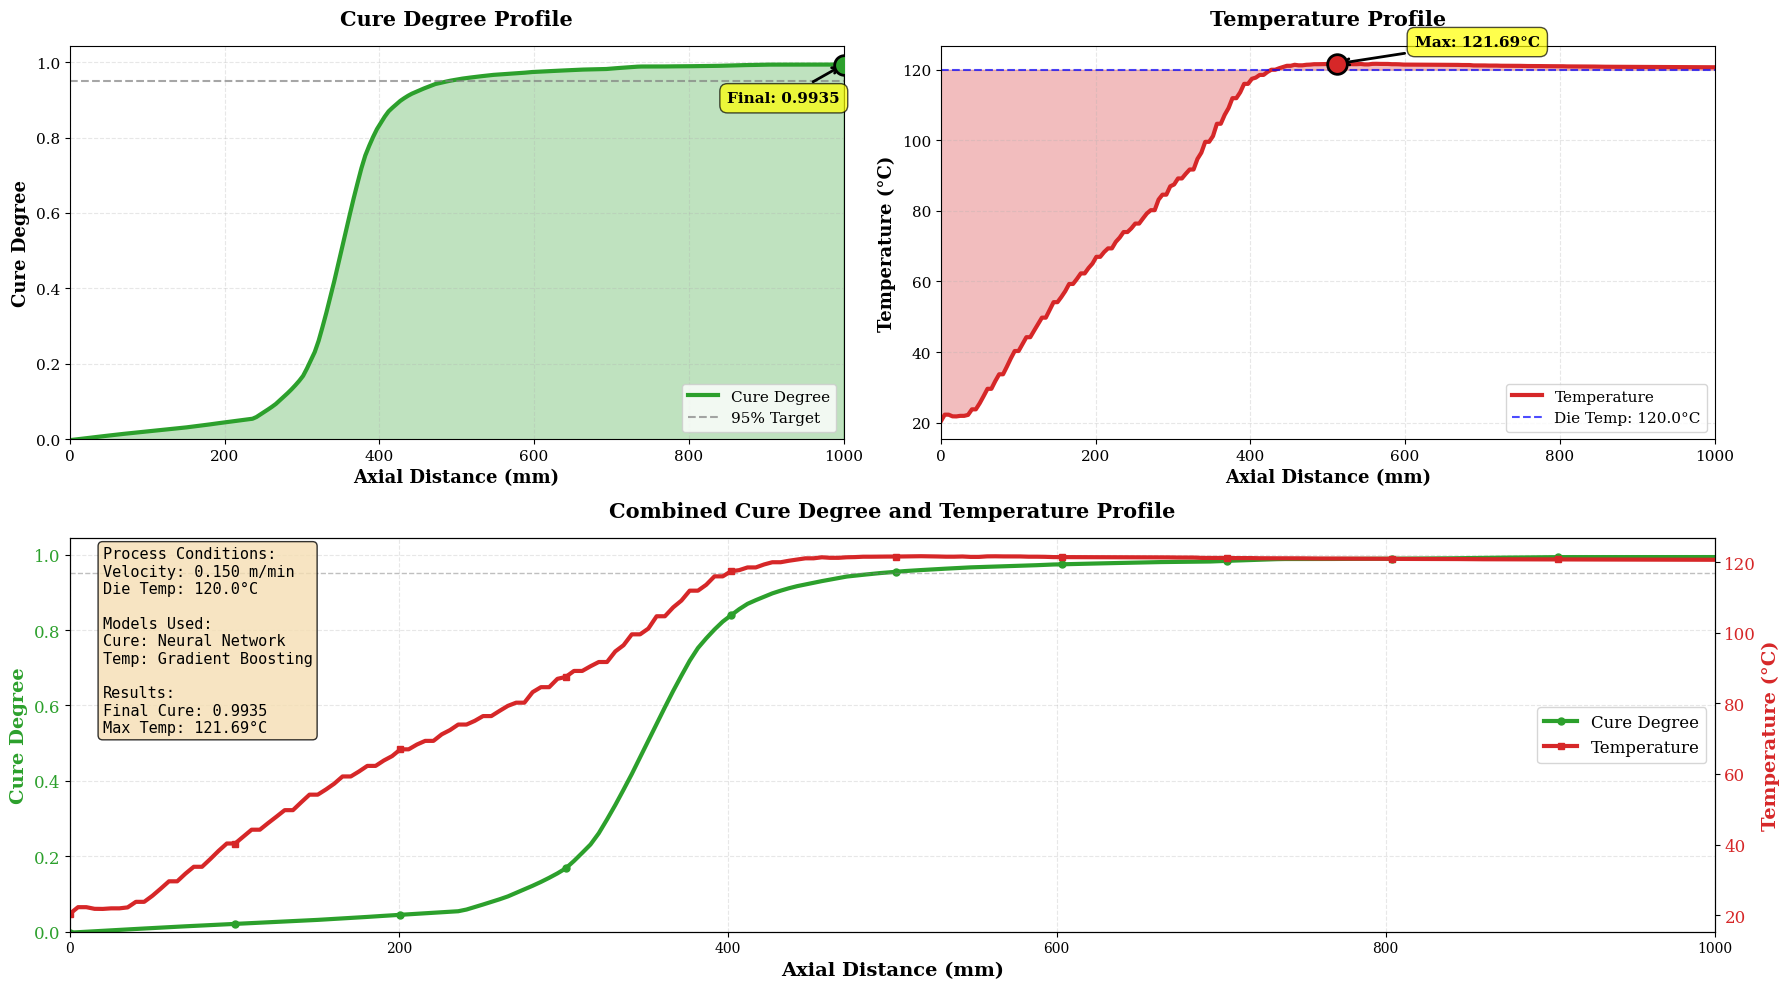


✓ Visualization saved as:
  • prediction_V0.15_T120.png (600 dpi)
  • prediction_V0.15_T120.pdf (vector)

💾 Step 5: Exporting Data...

✓ Data exported to: prediction_V0.15_T120_results.xlsx

✅ PREDICTION COMPLETE!

📁 Generated Files:
  1. prediction_V0.15_T120.png - High-resolution plot (600 dpi)
  2. prediction_V0.15_T120.pdf - Vector graphics plot
  3. prediction_V0.15_T120_results.xlsx - Complete data export

📊 Excel File Contents:
  • Summary sheet: All key metrics + computational performance
  • Profiles sheet: Axial distance (0-1000mm) vs Cure & Temperature (200 data points)

⚡ Computational Performance Summary:
  • ML Prediction: 0.0252 s (25.24 ms)
  • Simulation: 435 s (7.25 min)
  • Speedup: 17237× faster

  💡 For your paper: ML prediction is 17237 times faster than simulation
     (99.99% time reduction)

Thank you for using the Pultrusion Process Predictor!
To make another prediction, simply run the script again.


In [ ]:
"""
=============================================================================
PULTRUSION PROCESS PREDICTOR - AI-BASED PREDICTION TOOL
=============================================================================
This tool uses pre-trained machine learning models to predict cure degree
and temperature profiles for pultrusion processes.

Requirements:
- models_cure.pkl
- models_temp.pkl

Upload these model files before running this script.
=============================================================================
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from google.colab import files
import warnings
import time
warnings.filterwarnings('ignore')

# Set Times New Roman font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif', 'Liberation Serif']
plt.rcParams['mathtext.fontset'] = 'stix'

print("=" * 80)
print(" " * 15 + "PULTRUSION PROCESS PREDICTOR")
print(" " * 20 + "AI-Based Prediction Tool")
print("=" * 80)

# ===== LOAD PRE-TRAINED MODELS =====
print("\n📂 Step 1: Loading Pre-Trained Models")
print("-" * 80)

try:
    # Try to load models if they exist
    with open('models_cure.pkl', 'rb') as f:
        models_cure = pickle.load(f)
    with open('models_temp.pkl', 'rb') as f:
        models_temp = pickle.load(f)
    print("✓ Models loaded successfully from current directory!")

except (FileNotFoundError, EOFError, pickle.UnpicklingError) as e:
    # If not found or corrupted, prompt user to upload
    print(f"⚠ Model loading issue: {type(e).__name__}")
    print("Please upload the trained model files.")
    print("\nPlease upload 'models_cure.pkl':")
    uploaded_cure = files.upload()
    cure_filename = list(uploaded_cure.keys())[0]

    print("\nPlease upload 'models_temp.pkl':")
    uploaded_temp = files.upload()
    temp_filename = list(uploaded_temp.keys())[0]

    # Load the uploaded models
    try:
        with open(cure_filename, 'rb') as f:
            models_cure = pickle.load(f)
        with open(temp_filename, 'rb') as f:
            models_temp = pickle.load(f)
        print("\n✓ Models uploaded and loaded successfully!")
    except Exception as e:
        print(f"\n❌ Error loading models: {e}")
        print("\nPlease ensure you're uploading the correct model files from the training script.")
        print("If the problem persists, you may need to re-run the training script.")
        raise

# Get available models
available_models = list(models_cure.keys())
print(f"\n📊 Available Models: {', '.join(available_models)}")

# Automatically use best models (determined from training)
cure_model_name = 'Neural Network'  # Best for cure prediction
temp_model_name = 'Gradient Boosting'  # Best for temperature prediction

print(f"\n✓ Using best models:")
print(f"  • Cure Prediction: {cure_model_name}")
print(f"  • Temperature Prediction: {temp_model_name}")

# ===== PREDICTION FUNCTION =====
def predict_profile(velocity, die_temperature, models_cure, models_temp,
                    cure_model_name='Neural Network', temp_model_name='Gradient Boosting'):
    """
    Predict complete cure and temperature profiles along the die.

    Parameters:
    -----------
    velocity : float
        Pulling velocity in m/min
    die_temperature : float
        Die temperature in °C
    cure_model_name : str
        Model to use for cure prediction (default: 'Neural Network')
    temp_model_name : str
        Model to use for temperature prediction (default: 'Gradient Boosting')

    Returns:
    --------
    distances : array
        Axial distances (0-1000 mm)
    cure_profile : array
        Predicted cure degree profile
    temp_profile : array
        Predicted temperature profile
    """

    # Create axial distance array (0 to 1000 mm, 200 points)
    distances = np.linspace(0, 1000, 200)

    # Prepare input array [velocity, die_temp, distance] for each point
    X_input = np.array([[velocity, die_temperature, d] for d in distances])

    # Get models and scalers
    cure_model, cure_scaler_X, cure_scaler_y = models_cure[cure_model_name]
    temp_model, temp_scaler_X, temp_scaler_y = models_temp[temp_model_name]

    # Predict cure degree
    if cure_scaler_X is not None:
        X_scaled = cure_scaler_X.transform(X_input)
        cure_pred_scaled = cure_model.predict(X_scaled)
        cure_profile = cure_scaler_y.inverse_transform(cure_pred_scaled.reshape(-1, 1)).ravel()
    else:
        cure_profile = cure_model.predict(X_input)

    # Predict temperature
    if temp_scaler_X is not None:
        X_scaled = temp_scaler_X.transform(X_input)
        temp_pred_scaled = temp_model.predict(X_scaled)
        temp_profile = temp_scaler_y.inverse_transform(temp_pred_scaled.reshape(-1, 1)).ravel()
    else:
        temp_profile = temp_model.predict(X_input)

    return distances, cure_profile, temp_profile

# ===== USER INPUT =====
print("\n" + "=" * 80)
print("⚙️  Step 2: Enter Process Parameters")
print("=" * 80)

# Get input from user
velocity = float(input("\n➤ Enter pulling velocity (m/min): "))
die_temperature = float(input("➤ Enter die temperature (°C): "))

# ===== MAKE PREDICTIONS =====
print("\n" + "=" * 80)
print("🔮 Step 3: Generating Predictions...")
print("=" * 80)

# Start timing
start_time = time.time()

distances, cure_profile, temp_profile = predict_profile(
    velocity, die_temperature, models_cure, models_temp
)

# End timing
end_time = time.time()
prediction_time = end_time - start_time

# Calculate key metrics
final_cure_degree = cure_profile[-1]
max_temperature = temp_profile.max()
max_temp_location = distances[np.argmax(temp_profile)]

print(f"✓ Prediction completed in {prediction_time:.4f} seconds ({prediction_time*1000:.2f} milliseconds)")

# ===== DISPLAY RESULTS =====
print("\n" + "=" * 80)
print("📋 PREDICTION RESULTS")
print("=" * 80)

print("\n🔧 Input Conditions:")
print(f"  • Pulling Velocity    : {velocity:.3f} m/min")
print(f"  • Die Temperature     : {die_temperature:.1f}°C")
print(f"\n🤖 Models Used:")
print(f"  • Cure Prediction     : {cure_model_name} (R² = 0.999797)")
print(f"  • Temperature Prediction : {temp_model_name} (R² = 0.999832)")

print("\n📊 Key Predictions:")
print(f"  • Final Cure Degree (at 1000mm) : {final_cure_degree:.6f} ({final_cure_degree*100:.2f}%)")
print(f"  • Maximum Temperature            : {max_temperature:.2f}°C")
print(f"  • Max Temp Location              : {max_temp_location:.1f} mm")

print("\n⚡ Computational Performance:")
print(f"  • ML Prediction Time             : {prediction_time:.4f} seconds ({prediction_time*1000:.2f} ms)")
print(f"  • Equivalent Simulation Time     : 435 seconds (7.25 minutes)")
print(f"  • Speedup Factor                 : {435/prediction_time:.0f}×")
print(f"  • Time Savings                   : {((435-prediction_time)/435*100):.2f}%")

# Check if fully cured
if final_cure_degree >= 0.95:
    cure_status = "✓ FULLY CURED"
    cure_color = "green"
elif final_cure_degree >= 0.90:
    cure_status = "⚠ PARTIALLY CURED"
    cure_color = "orange"
else:
    cure_status = "✗ UNDER-CURED"
    cure_color = "red"

print(f"\n🎯 Cure Status: {cure_status}")

# ===== CREATE VISUALIZATION =====
print("\n" + "=" * 80)
print("📈 Step 4: Creating Visualization...")
print("=" * 80)

# Create comprehensive plot
fig = plt.figure(figsize=(18, 10))

# Define color scheme based on cure status
if final_cure_degree >= 0.95:
    cure_color_plot = '#2ca02c'  # Green
elif final_cure_degree >= 0.90:
    cure_color_plot = '#ff7f0e'  # Orange
else:
    cure_color_plot = '#d62728'  # Red

# Plot 1: Cure Degree Profile
ax1 = plt.subplot(2, 2, 1)
ax1.plot(distances, cure_profile, linewidth=3, color=cure_color_plot, label='Cure Degree')
ax1.axhline(y=0.95, color='gray', linestyle='--', linewidth=1.5, alpha=0.7, label='95% Target')
ax1.fill_between(distances, 0, cure_profile, alpha=0.3, color=cure_color_plot)
ax1.scatter([1000], [final_cure_degree], s=200, color=cure_color_plot,
            edgecolors='black', linewidths=2, zorder=5, marker='o')
ax1.set_xlabel('Axial Distance (mm)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Cure Degree', fontsize=13, fontweight='bold')
ax1.set_title('Cure Degree Profile', fontsize=15, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(fontsize=11, loc='lower right')
ax1.set_xlim(0, 1000)
ax1.set_ylim(0, max(1.0, cure_profile.max() * 1.05))
ax1.tick_params(labelsize=11)

# Add annotation for final cure
ax1.annotate(f'Final: {final_cure_degree:.4f}',
             xy=(1000, final_cure_degree), xytext=(850, final_cure_degree - 0.1),
             fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', lw=2))

# Plot 2: Temperature Profile
ax2 = plt.subplot(2, 2, 2)
ax2.plot(distances, temp_profile, linewidth=3, color='#d62728', label='Temperature')
ax2.axhline(y=die_temperature, color='blue', linestyle='--', linewidth=1.5,
            alpha=0.7, label=f'Die Temp: {die_temperature}°C')
ax2.fill_between(distances, die_temperature, temp_profile, alpha=0.3, color='#d62728')
ax2.scatter([max_temp_location], [max_temperature], s=200, color='#d62728',
            edgecolors='black', linewidths=2, zorder=5, marker='o')
ax2.set_xlabel('Axial Distance (mm)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Temperature (°C)', fontsize=13, fontweight='bold')
ax2.set_title('Temperature Profile', fontsize=15, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(fontsize=11, loc='best')
ax2.set_xlim(0, 1000)
ax2.tick_params(labelsize=11)

# Add annotation for max temperature
ax2.annotate(f'Max: {max_temperature:.2f}°C',
             xy=(max_temp_location, max_temperature),
             xytext=(max_temp_location + 100, max_temperature + 5),
             fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', lw=2))

# Plot 3: Combined View
ax3 = plt.subplot(2, 1, 2)
ax3_temp = ax3.twinx()

# Plot cure on left axis
line1 = ax3.plot(distances, cure_profile, linewidth=3, color=cure_color_plot,
                 label='Cure Degree', marker='o', markevery=20, markersize=5)
ax3.axhline(y=0.95, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax3.set_xlabel('Axial Distance (mm)', fontsize=14, fontweight='bold')
ax3.set_ylabel('Cure Degree', fontsize=14, fontweight='bold', color=cure_color_plot)
ax3.tick_params(axis='y', labelcolor=cure_color_plot, labelsize=12)
ax3.set_xlim(0, 1000)
ax3.set_ylim(0, max(1.0, cure_profile.max() * 1.05))
ax3.grid(True, alpha=0.3, linestyle='--')

# Plot temperature on right axis
line2 = ax3_temp.plot(distances, temp_profile, linewidth=3, color='#d62728',
                      label='Temperature', marker='s', markevery=20, markersize=5)
ax3_temp.set_ylabel('Temperature (°C)', fontsize=14, fontweight='bold', color='#d62728')
ax3_temp.tick_params(axis='y', labelcolor='#d62728', labelsize=12)

# Combined legend
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax3.legend(lines, labels, fontsize=12, loc='center right')

ax3.set_title('Combined Cure Degree and Temperature Profile',
              fontsize=15, fontweight='bold', pad=15)

# Add process conditions text box
textstr = f'Process Conditions:\n'
textstr += f'Velocity: {velocity:.3f} m/min\n'
textstr += f'Die Temp: {die_temperature:.1f}°C\n\n'
textstr += f'Models Used:\n'
textstr += f'Cure: {cure_model_name}\n'
textstr += f'Temp: {temp_model_name}\n\n'
textstr += f'Results:\n'
textstr += f'Final Cure: {final_cure_degree:.4f}\n'
textstr += f'Max Temp: {max_temperature:.2f}°C'

props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax3.text(0.02, 0.98, textstr, transform=ax3.transAxes, fontsize=11,
         verticalalignment='top', bbox=props, family='monospace')

plt.tight_layout()

# Save figure
filename_base = f'prediction_V{velocity:.2f}_T{die_temperature:.0f}'
plt.savefig(f'{filename_base}.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig(f'{filename_base}.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✓ Visualization saved as:")
print(f"  • {filename_base}.png (600 dpi)")
print(f"  • {filename_base}.pdf (vector)")

# ===== EXPORT DATA TO EXCEL =====
print("\n" + "=" * 80)
print("💾 Step 5: Exporting Data...")
print("=" * 80)

# Create dataframe with results
results_df = pd.DataFrame({
    'Axial_Distance_mm': distances,
    'Cure_Degree': cure_profile,
    'Temperature_C': temp_profile
})

# Create summary dataframe
summary_df = pd.DataFrame({
    'Parameter': ['Velocity (m/min)', 'Die Temperature (°C)',
                  'Final Cure Degree', 'Final Cure (%)',
                  'Max Temperature (°C)', 'Max Temp Location (mm)'],
    'Value': [velocity, die_temperature, final_cure_degree,
              final_cure_degree*100, max_temperature, max_temp_location]
})

# Export to Excel
excel_filename = f'{filename_base}_results.xlsx'
with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
    summary_df.to_excel(writer, sheet_name='Summary', index=False)
    results_df.to_excel(writer, sheet_name='Profiles', index=False)

print(f"\n✓ Data exported to: {excel_filename}")

# ===== FINAL SUMMARY =====
print("\n" + "=" * 80)
print("✅ PREDICTION COMPLETE!")
print("=" * 80)

print(f"\n📁 Generated Files:")
print(f"  1. {filename_base}.png - High-resolution plot (600 dpi)")
print(f"  2. {filename_base}.pdf - Vector graphics plot")
print(f"  3. {excel_filename} - Complete data export")

print(f"\n📊 Excel File Contents:")
print(f"  • Summary sheet: All key metrics + computational performance")
print(f"  • Profiles sheet: Axial distance (0-1000mm) vs Cure & Temperature ({len(distances)} data points)")

print(f"\n⚡ Computational Performance Summary:")
print(f"  • ML Prediction: {prediction_time:.4f} s ({prediction_time*1000:.2f} ms)")
print(f"  • Simulation: 435 s (7.25 min)")
print(f"  • Speedup: {435/prediction_time:.0f}× faster")
print(f"\n  💡 For your paper: ML prediction is {435/prediction_time:.0f} times faster than simulation")
print(f"     ({((435-prediction_time)/435*100):.2f}% time reduction)")

print("\n" + "=" * 80)
print("Thank you for using the Pultrusion Process Predictor!")
print("To make another prediction, simply run the script again.")
print("=" * 80)

# **Use of trained ML Models for Optimisation of Process Parameters**

               PULTRUSION PROCESS OPTIMIZER
                  Inverse Design Tool

📂 Step 1: Loading Pre-Trained Models
--------------------------------------------------------------------------------
✓ Models loaded successfully!

✓ Using best models:
  • Cure: Neural Network
  • Temp: Gradient Boosting

⚙️  Step 2: Define Optimization Target & Constraints

➤ Enter target cure degree (0-1, e.g., 0.95): 0.99

📏 Define parameter ranges (should match training data range):
   ⚠️  WARNING: Using ranges outside training data may give unreliable results!
  • Minimum velocity (m/min) [e.g., 0.11]: 0.11
  • Maximum velocity (m/min) [e.g., 0.21]: 0.21
  • Minimum die temperature (°C) [e.g., 110]: 110
  • Maximum die temperature (°C) [e.g., 140]: 140

🌡️  Temperature constraint:
  • Set maximum temperature limit? (yes/no): yes
    Enter max temperature limit (°C): 145

🎯 Optimization objective:
  1. Minimize maximum temperature (recommended)
  2. Maximize velocity (faster production)
  3. Minimi

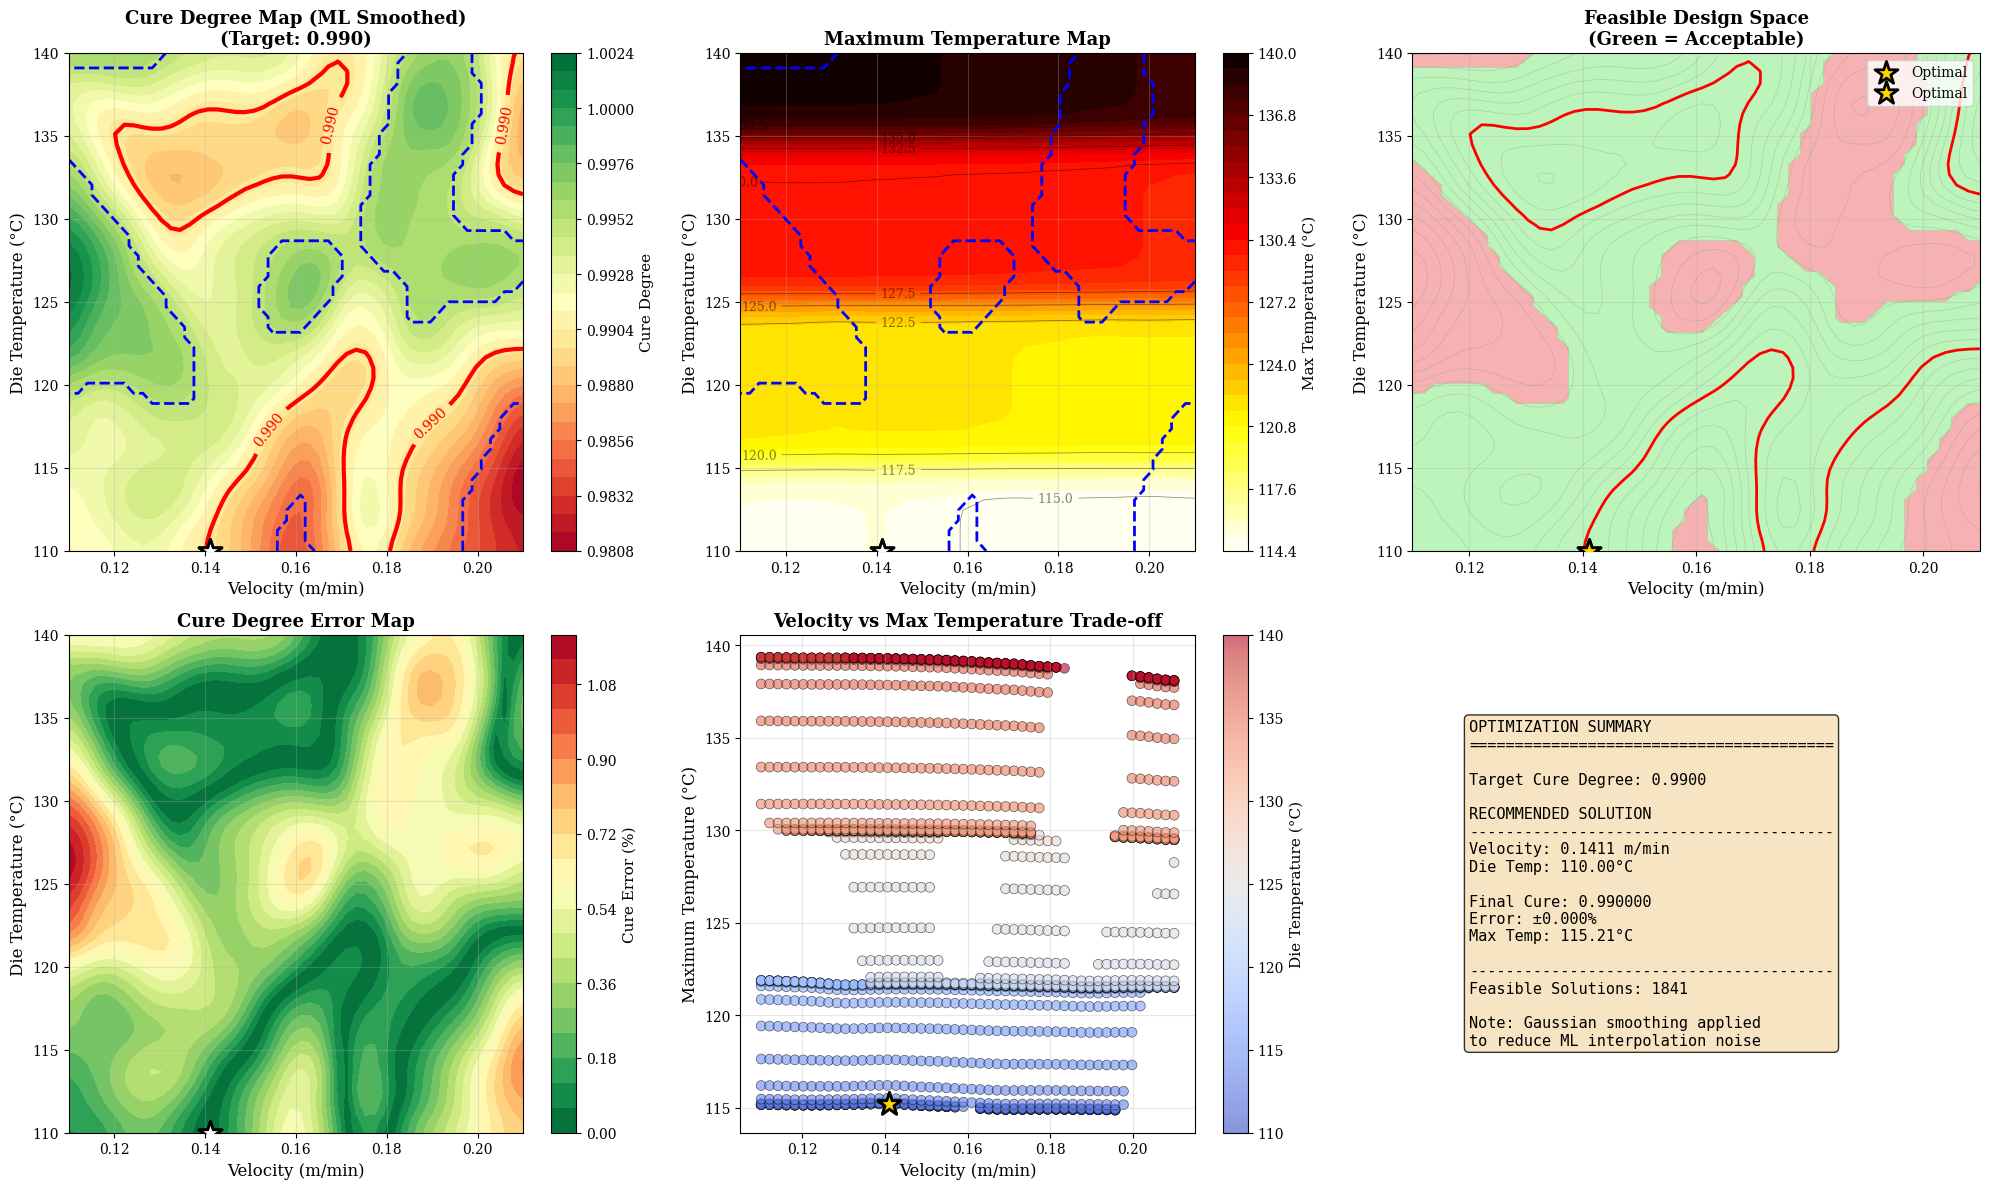


✓ Visualization saved as 'optimization_target0.990.png' and 'optimization_target0.990.pdf'
✓ Results exported to 'optimization_target0.990_results.xlsx'

✅ OPTIMIZATION COMPLETE!

Generated files:
  • optimization_target0.990.png (600 dpi)
  • optimization_target0.990.pdf (vector)
  • optimization_target0.990_results.xlsx



In [ ]:
"""
=============================================================================
PULTRUSION PROCESS OPTIMIZER - INVERSE DESIGN TOOL
=============================================================================
Given a target cure degree, this tool finds optimal velocity and temperature
combinations to achieve the desired cure while minimizing temperature.

Requirements:
- models_cure.pkl
- models_temp.pkl
=============================================================================
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from google.colab import files
from scipy.optimize import minimize, differential_evolution
from scipy.ndimage import gaussian_filter
import warnings
warnings.filterwarnings('ignore')

# Set Times New Roman font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif', 'Liberation Serif']
plt.rcParams['mathtext.fontset'] = 'stix'

print("=" * 80)
print(" " * 15 + "PULTRUSION PROCESS OPTIMIZER")
print(" " * 18 + "Inverse Design Tool")
print("=" * 80)

# ===== LOAD PRE-TRAINED MODELS =====
print("\n📂 Step 1: Loading Pre-Trained Models")
print("-" * 80)

try:
    with open('models_cure.pkl', 'rb') as f:
        models_cure = pickle.load(f)
    with open('models_temp.pkl', 'rb') as f:
        models_temp = pickle.load(f)
    print("✓ Models loaded successfully!")

except (FileNotFoundError, EOFError, pickle.UnpicklingError) as e:
    print(f"⚠ Model loading issue: {type(e).__name__}")
    print("\nPlease upload 'models_cure.pkl':")
    uploaded_cure = files.upload()
    cure_filename = list(uploaded_cure.keys())[0]

    print("\nPlease upload 'models_temp.pkl':")
    uploaded_temp = files.upload()
    temp_filename = list(uploaded_temp.keys())[0]

    with open(cure_filename, 'rb') as f:
        models_cure = pickle.load(f)
    with open(temp_filename, 'rb') as f:
        models_temp = pickle.load(f)
    print("\n✓ Models uploaded and loaded successfully!")

# Use best models
cure_model_name = 'Neural Network'
temp_model_name = 'Gradient Boosting'
cure_model, cure_scaler_X, cure_scaler_y = models_cure[cure_model_name]
temp_model, temp_scaler_X, temp_scaler_y = models_temp[temp_model_name]

print(f"\n✓ Using best models:")
print(f"  • Cure: {cure_model_name}")
print(f"  • Temp: {temp_model_name}")

# ===== PREDICTION FUNCTIONS =====
def predict_final_cure(velocity, die_temp):
    """Predict final cure degree at 1000mm"""
    X = np.array([[velocity, die_temp, 1000]])
    if cure_scaler_X is not None:
        X_scaled = cure_scaler_X.transform(X)
        pred_scaled = cure_model.predict(X_scaled)
        return cure_scaler_y.inverse_transform(pred_scaled.reshape(-1, 1))[0, 0]
    return cure_model.predict(X)[0]

def predict_max_temp(velocity, die_temp):
    """Predict maximum temperature along the die"""
    distances = np.linspace(0, 1000, 100)
    X = np.array([[velocity, die_temp, d] for d in distances])
    if temp_scaler_X is not None:
        X_scaled = temp_scaler_X.transform(X)
        pred_scaled = temp_model.predict(X_scaled)
        temps = temp_scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).ravel()
    else:
        temps = temp_model.predict(X)
    return temps.max()

# ===== USER INPUT =====
print("\n" + "=" * 80)
print("⚙️  Step 2: Define Optimization Target & Constraints")
print("=" * 80)

target_cure = float(input("\n➤ Enter target cure degree (0-1, e.g., 0.95): "))

print("\n📏 Define parameter ranges (should match training data range):")
print("   ⚠️  WARNING: Using ranges outside training data may give unreliable results!")
vel_min = float(input("  • Minimum velocity (m/min) [e.g., 0.11]: "))
vel_max = float(input("  • Maximum velocity (m/min) [e.g., 0.21]: "))
temp_min = float(input("  • Minimum die temperature (°C) [e.g., 110]: "))
temp_max = float(input("  • Maximum die temperature (°C) [e.g., 140]: "))

print("\n🌡️  Temperature constraint:")
temp_limit_option = input("  • Set maximum temperature limit? (yes/no): ").lower()
if temp_limit_option in ['yes', 'y']:
    max_temp_limit = float(input("    Enter max temperature limit (°C): "))
else:
    max_temp_limit = None

print("\n🎯 Optimization objective:")
print("  1. Minimize maximum temperature (recommended)")
print("  2. Maximize velocity (faster production)")
print("  3. Minimize die temperature (energy saving)")
objective_choice = input("  • Select objective (1-3): ")

# ===== OPTIMIZATION SETUP =====
print("\n" + "=" * 80)
print("🔬 Step 3: Running Optimization...")
print("=" * 80)

def objective_function(x):
    """
    Objective function to minimize
    x[0] = velocity, x[1] = die_temperature
    """
    velocity, die_temp = x

    # Primary goal: match target cure degree
    cure_pred = predict_final_cure(velocity, die_temp)
    cure_error = (cure_pred - target_cure) ** 2

    # Secondary objectives (weighted)
    if objective_choice == '1':
        # Minimize maximum temperature
        max_temp = predict_max_temp(velocity, die_temp)
        secondary = max_temp * 0.01
    elif objective_choice == '2':
        # Maximize velocity (faster production) = minimize negative velocity
        secondary = -velocity * 100
    else:  # objective_choice == '3'
        # Minimize die temperature (save energy)
        secondary = die_temp * 0.1

    # Combined objective (heavily weight cure accuracy)
    return cure_error * 10000 + secondary

def constraint_cure(x):
    """Constraint: cure degree must be within tolerance"""
    velocity, die_temp = x
    cure_pred = predict_final_cure(velocity, die_temp)
    return abs(cure_pred - target_cure) - 0.005  # ±0.5% tolerance

def constraint_max_temp(x):
    """Constraint: maximum temperature must be below limit"""
    if max_temp_limit is None:
        return 1.0  # No constraint
    velocity, die_temp = x
    max_temp = predict_max_temp(velocity, die_temp)
    return max_temp_limit - max_temp

# Set up constraints
constraints = []
if max_temp_limit is not None:
    constraints.append({'type': 'ineq', 'fun': constraint_max_temp})

# Bounds
bounds = [(vel_min, vel_max), (temp_min, temp_max)]

# ===== RUN MULTIPLE OPTIMIZATION METHODS =====
print("\n🔍 Finding optimal solutions using multiple methods...")

# Method 1: Differential Evolution (global optimizer)
print("\n  1. Running global optimization (Differential Evolution)...")
result_de = differential_evolution(
    objective_function,
    bounds,
    maxiter=500,
    popsize=30,
    seed=42,
    polish=True,
    atol=1e-6
)

# Method 2: Local optimization from multiple starting points
print("  2. Running local optimizations from multiple starting points...")
best_local_result = None
best_local_score = np.inf

n_starts = 20
for i in range(n_starts):
    x0 = [
        np.random.uniform(vel_min, vel_max),
        np.random.uniform(temp_min, temp_max)
    ]

    try:
        result_local = minimize(
            objective_function,
            x0,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'ftol': 1e-9}
        )

        if result_local.fun < best_local_score:
            best_local_score = result_local.fun
            best_local_result = result_local
    except:
        continue

# ===== COLLECT SOLUTIONS =====
solutions = []

# Add global solution
if result_de.success:
    vel_opt, temp_opt = result_de.x
    cure_opt = predict_final_cure(vel_opt, temp_opt)
    max_temp_opt = predict_max_temp(vel_opt, temp_opt)

    solutions.append({
        'Method': 'Global (DE)',
        'Velocity (m/min)': vel_opt,
        'Die Temperature (°C)': temp_opt,
        'Final Cure': cure_opt,
        'Cure Error (%)': abs(cure_opt - target_cure) * 100,
        'Max Temperature (°C)': max_temp_opt,
        'Objective Score': result_de.fun
    })

# Add best local solution
if best_local_result is not None and best_local_result.success:
    vel_opt, temp_opt = best_local_result.x
    cure_opt = predict_final_cure(vel_opt, temp_opt)
    max_temp_opt = predict_max_temp(vel_opt, temp_opt)

    solutions.append({
        'Method': 'Local (SLSQP)',
        'Velocity (m/min)': vel_opt,
        'Die Temperature (°C)': temp_opt,
        'Final Cure': cure_opt,
        'Cure Error (%)': abs(cure_opt - target_cure) * 100,
        'Max Temperature (°C)': max_temp_opt,
        'Objective Score': best_local_result.fun
    })

# ===== GRID SEARCH FOR VISUALIZATION =====
print("  3. Exploring design space (grid search)...")
print("     ⚠️  Note: ML predictions between training points may have uncertainty")

vel_grid = np.linspace(vel_min, vel_max, 50)
temp_grid = np.linspace(temp_min, temp_max, 50)
VEL, TEMP = np.meshgrid(vel_grid, temp_grid)

CURE = np.zeros_like(VEL)
MAX_TEMP = np.zeros_like(VEL)

for i in range(len(temp_grid)):
    for j in range(len(vel_grid)):
        CURE[i, j] = predict_final_cure(VEL[i, j], TEMP[i, j])
        MAX_TEMP[i, j] = predict_max_temp(VEL[i, j], TEMP[i, j])

# Apply smoothing to reduce interpolation artifacts
from scipy.ndimage import gaussian_filter
CURE_smooth = gaussian_filter(CURE, sigma=1.5)
MAX_TEMP_smooth = gaussian_filter(MAX_TEMP, sigma=1.5)

# ===== FIND FEASIBLE SOLUTIONS =====
# Find all points within tolerance (using smoothed data for more robust feasibility)
tolerance = 0.005  # ±0.5%
feasible_mask = np.abs(CURE_smooth - target_cure) <= tolerance

if max_temp_limit is not None:
    feasible_mask = feasible_mask & (MAX_TEMP_smooth <= max_temp_limit)

feasible_count = np.sum(feasible_mask)

# ===== DISPLAY RESULTS =====
print("\n" + "=" * 80)
print("📊 OPTIMIZATION RESULTS")
print("=" * 80)

print(f"\n🎯 Target: Cure Degree = {target_cure:.4f}")
print(f"📏 Constraints:")
print(f"   • Velocity: {vel_min:.3f} - {vel_max:.3f} m/min")
print(f"   • Die Temperature: {temp_min:.0f} - {temp_max:.0f}°C")
if max_temp_limit:
    print(f"   • Max Temperature Limit: {max_temp_limit:.0f}°C")

if solutions:
    print("\n" + "-" * 80)
    print("🏆 OPTIMAL SOLUTIONS")
    print("-" * 80)

    solutions_df = pd.DataFrame(solutions)
    print(solutions_df.to_string(index=False))

    # Best solution
    best_idx = solutions_df['Objective Score'].idxmin()
    best_sol = solutions_df.iloc[best_idx]

    print("\n" + "=" * 80)
    print("✨ RECOMMENDED SOLUTION")
    print("=" * 80)
    print(f"\n🔧 Operating Conditions:")
    print(f"   • Velocity: {best_sol['Velocity (m/min)']:.4f} m/min")
    print(f"   • Die Temperature: {best_sol['Die Temperature (°C)']:.2f}°C")
    print(f"\n📊 Predicted Performance:")
    print(f"   • Final Cure Degree: {best_sol['Final Cure']:.6f} ({best_sol['Final Cure']*100:.2f}%)")
    print(f"   • Cure Error: ±{best_sol['Cure Error (%)']:.3f}%")
    print(f"   • Maximum Temperature: {best_sol['Max Temperature (°C)']:.2f}°C")

    if feasible_count > 0:
        print(f"\n✓ Found {feasible_count} feasible parameter combinations in design space")
else:
    print("\n⚠ No optimal solution found within constraints!")
    print("   Try relaxing constraints or adjusting target cure degree.")

# ===== VISUALIZATION =====
print("\n" + "=" * 80)
print("📈 Step 4: Creating Design Space Visualization...")
print("=" * 80)

fig = plt.figure(figsize=(20, 12))

# Plot 1: Cure Degree Contours
ax1 = plt.subplot(2, 3, 1)
contour1 = ax1.contourf(VEL, TEMP, CURE_smooth, levels=30, cmap='RdYlGn')
contour1_lines = ax1.contour(VEL, TEMP, CURE_smooth, levels=[target_cure], colors='red', linewidths=3)
ax1.clabel(contour1_lines, inline=True, fontsize=10, fmt=f'{target_cure:.3f}')
cbar1 = plt.colorbar(contour1, ax=ax1)
cbar1.set_label('Cure Degree', fontsize=11)

# Mark feasible region
if feasible_count > 0:
    ax1.contour(VEL, TEMP, feasible_mask.astype(int), levels=[0.5], colors='blue', linewidths=2, linestyles='--')

# Mark optimal solutions
for sol in solutions:
    ax1.scatter(sol['Velocity (m/min)'], sol['Die Temperature (°C)'],
                s=300, c='white', marker='*', edgecolors='black', linewidths=2, zorder=10)

ax1.set_xlabel('Velocity (m/min)', fontsize=12)
ax1.set_ylabel('Die Temperature (°C)', fontsize=12)
ax1.set_title(f'Cure Degree Map (ML Smoothed)\n(Target: {target_cure:.3f})', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Maximum Temperature Contours
ax2 = plt.subplot(2, 3, 2)
contour2 = ax2.contourf(VEL, TEMP, MAX_TEMP_smooth, levels=30, cmap='hot_r')
contour2_lines = ax2.contour(VEL, TEMP, MAX_TEMP_smooth, levels=10, colors='black', linewidths=0.5, alpha=0.5)
ax2.clabel(contour2_lines, inline=True, fontsize=9, fmt='%.1f')
cbar2 = plt.colorbar(contour2, ax=ax2)
cbar2.set_label('Max Temperature (°C)', fontsize=11)

# Mark temperature limit
if max_temp_limit:
    ax2.contour(VEL, TEMP, MAX_TEMP_smooth, levels=[max_temp_limit], colors='red', linewidths=3, linestyles='--')

# Mark feasible region
if feasible_count > 0:
    ax2.contour(VEL, TEMP, feasible_mask.astype(int), levels=[0.5], colors='blue', linewidths=2, linestyles='--')

# Mark optimal solutions
for sol in solutions:
    ax2.scatter(sol['Velocity (m/min)'], sol['Die Temperature (°C)'],
                s=300, c='white', marker='*', edgecolors='black', linewidths=2, zorder=10)

ax2.set_xlabel('Velocity (m/min)', fontsize=12)
ax2.set_ylabel('Die Temperature (°C)', fontsize=12)
ax2.set_title('Maximum Temperature Map', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Plot 3: Feasible Region
ax3 = plt.subplot(2, 3, 3)
ax3.contourf(VEL, TEMP, feasible_mask.astype(float), levels=[0, 0.5, 1], colors=['lightcoral', 'lightgreen'], alpha=0.6)
ax3.contour(VEL, TEMP, CURE_smooth, levels=20, colors='gray', linewidths=0.5, alpha=0.3)
ax3.contour(VEL, TEMP, CURE_smooth, levels=[target_cure], colors='red', linewidths=2)

# Mark optimal solutions
for sol in solutions:
    ax3.scatter(sol['Velocity (m/min)'], sol['Die Temperature (°C)'],
                s=300, c='gold', marker='*', edgecolors='black', linewidths=2, zorder=10,
                label='Optimal')

ax3.set_xlabel('Velocity (m/min)', fontsize=12)
ax3.set_ylabel('Die Temperature (°C)', fontsize=12)
ax3.set_title(f'Feasible Design Space\n(Green = Acceptable)', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend(fontsize=10)

# Plot 4: Cure Error Map
ax4 = plt.subplot(2, 3, 4)
cure_error = np.abs(CURE_smooth - target_cure) * 100
contour4 = ax4.contourf(VEL, TEMP, cure_error, levels=20, cmap='RdYlGn_r')
cbar4 = plt.colorbar(contour4, ax=ax4)
cbar4.set_label('Cure Error (%)', fontsize=11)

for sol in solutions:
    ax4.scatter(sol['Velocity (m/min)'], sol['Die Temperature (°C)'],
                s=300, c='white', marker='*', edgecolors='black', linewidths=2, zorder=10)

ax4.set_xlabel('Velocity (m/min)', fontsize=12)
ax4.set_ylabel('Die Temperature (°C)', fontsize=12)
ax4.set_title('Cure Degree Error Map', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Plot 5: Trade-off Analysis
if feasible_count > 0:
    ax5 = plt.subplot(2, 3, 5)

    # Extract feasible points
    feasible_vel = VEL[feasible_mask]
    feasible_temp = TEMP[feasible_mask]
    feasible_max_temp = MAX_TEMP_smooth[feasible_mask]

    scatter = ax5.scatter(feasible_vel, feasible_max_temp, c=feasible_temp,
                         s=50, cmap='coolwarm', alpha=0.6, edgecolors='black', linewidths=0.5)
    cbar5 = plt.colorbar(scatter, ax=ax5)
    cbar5.set_label('Die Temperature (°C)', fontsize=11)

    # Mark optimal solutions
    for sol in solutions:
        ax5.scatter(sol['Velocity (m/min)'], sol['Max Temperature (°C)'],
                    s=300, c='gold', marker='*', edgecolors='black', linewidths=2, zorder=10)

    ax5.set_xlabel('Velocity (m/min)', fontsize=12)
    ax5.set_ylabel('Maximum Temperature (°C)', fontsize=12)
    ax5.set_title('Velocity vs Max Temperature Trade-off', fontsize=13, fontweight='bold')
    ax5.grid(True, alpha=0.3)

# Plot 6: Summary Information
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')

summary_text = f"OPTIMIZATION SUMMARY\n{'=' * 40}\n\n"
summary_text += f"Target Cure Degree: {target_cure:.4f}\n\n"

if solutions:
    summary_text += f"{'RECOMMENDED SOLUTION'}\n{'-' * 40}\n"
    summary_text += f"Velocity: {best_sol['Velocity (m/min)']:.4f} m/min\n"
    summary_text += f"Die Temp: {best_sol['Die Temperature (°C)']:.2f}°C\n\n"
    summary_text += f"Final Cure: {best_sol['Final Cure']:.6f}\n"
    summary_text += f"Error: ±{best_sol['Cure Error (%)']:.3f}%\n"
    summary_text += f"Max Temp: {best_sol['Max Temperature (°C)']:.2f}°C\n\n"
    summary_text += f"{'-' * 40}\n"
    summary_text += f"Feasible Solutions: {feasible_count}\n\n"
    summary_text += f"Note: Gaussian smoothing applied\nto reduce ML interpolation noise"
else:
    summary_text += "No optimal solution found!\n"

ax6.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
filename = f'optimization_target{target_cure:.3f}'
plt.savefig(f'{filename}.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig(f'{filename}.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✓ Visualization saved as '{filename}.png' and '{filename}.pdf'")

# ===== EXPORT RESULTS =====
if solutions:
    excel_filename = f'{filename}_results.xlsx'

    with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
        solutions_df.to_excel(writer, sheet_name='Optimal_Solutions', index=False)

        if feasible_count > 0:
            feasible_df = pd.DataFrame({
                'Velocity (m/min)': VEL[feasible_mask],
                'Die Temperature (°C)': TEMP[feasible_mask],
                'Cure Degree': CURE_smooth[feasible_mask],
                'Max Temperature (°C)': MAX_TEMP_smooth[feasible_mask]
            })
            feasible_df.to_excel(writer, sheet_name='All_Feasible_Solutions', index=False)

    print(f"✓ Results exported to '{excel_filename}'")

print("\n" + "=" * 80)
print("✅ OPTIMIZATION COMPLETE!")
print("=" * 80)
print("\nGenerated files:")
print(f"  • {filename}.png (600 dpi)")
print(f"  • {filename}.pdf (vector)")
if solutions:
    print(f"  • {excel_filename}")
print("\n" + "=" * 80)